In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit  # Numerically stable sigmoid function
from scipy.optimize import curve_fit
import statsmodels.api as sm
import networkx as nx
import folium
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm  # Import tqdm for progress tracking

# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

# Import Parameters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

# SIMULATION PARAMETERS

simulations = 100 # MAIN
# simulations = 10

# Specify the number of quantiles for centrality-based simulations
num_quantiles = 5

# Specify quantiles for distance-based simulations
quantiles = (np.arange(1, num_quantiles+1) / num_quantiles).tolist()

# Specify the v6-pathogen strain initial proportions across the entire landscape
percentages = [0.0, 0.25, 0.50, 0.75, 1.0] # MAIN
# percentages = [1.0]


# Specify the number of sprays applied in May for yards in given quantiles
increments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Specify initial probabilities for infections across the landscape
initial_probabilities = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01] # MAIN
# initial_probabilities = [0.001, 0.01]


# Specify the years
years = [2014, 2015, 2016, 2017] # MAIN
# years = [2014]


# Specify the demand levels
markets = ['low', 'moderate', 'high'] # MAIN
# markets = ['high']



# Lists to store the simulation results
year_list = []
quantile_list = []
mean_profit_percent_change_list = []
sprays_in_May_list = []
V6_percent_list = []
initial_prob_list = []
market_demand_list = []
simulation_list = []

# Lists to store the variety and yard information for each year
variety_list = []
variety_year_list = []
centrality_list = []


# Lists to store disease incidence information
disease_incidence_may_list = []
disease_incidence_jun_list = []
disease_incidence_jul_list = []

# lists to store the simulated sprays data
mean_sprays_may_list = []
mean_sprays_jun_list = []
mean_sprays_jul_list = []
mean_sprays_late_list = []

mean_sprays_may_baseline_list = []
mean_sprays_jun_baseline_list = []
mean_sprays_jul_baseline_list = []
mean_sprays_late_baseline_list = []

# Lists to store the fungicide cost data
mean_fung_cost_early_list = []
mean_fung_cost_may_list = []
mean_fung_cost_jun_list = []
mean_fung_cost_jul_list = []
mean_fung_cost_late_list = []
mean_fung_cost_list = []

mean_baseline_fung_cost_may_list = []
mean_baseline_fung_cost_jun_list = []
mean_baseline_fung_cost_jul_list = []
mean_baseline_fung_cost_late_list = []
mean_baseline_fung_cost_list = []

# lists to store revenue information
mean_price_list = []
mean_yield_list = []
mean_baseline_price_list = []
mean_baseline_yield_list = []

# cone color and cone incidence lists
mean_cone_color_list = []
mean_cone_incidence_list = []
mean_baseline_cone_color_list = []
mean_baseline_cone_incidence_list = []

# Initialize progress bars outside the loops
years_bar = tqdm(total=len(years), desc='🚀 Years', leave=False, position=0, colour='red')
simulations_bar = tqdm(total=simulations, desc='💻 Simulations', leave=False, position=1, colour='blue')
percentages_bar = tqdm(total=len(percentages), desc='📊 Percentages', leave=False, position=2, colour='green')
init_prob_bar = tqdm(total=len(initial_probabilities), desc='🎲 Init Probabilities', leave=False, position=3, colour='yellow')
quantiles_bar = tqdm(total=len(quantiles), desc='🧮 Quantiles', leave=False, position=4, colour='magenta')
increments_bar = tqdm(total=len(increments), desc='💧 Sprays in May', leave=False, position=5, colour='cyan')
markets_bar = tqdm(total=len(markets), desc='🌐 Markets', leave=False, position=6, colour='purple')

for year in years:
    # Update and reset the years progress bar
    years_bar.update(1)
    years_bar.set_postfix({'Year': year})
    
    
    period = ['may-jun', 'jun-jul']

    # Import data
    if year == 2014:
        X = np.load('../data/processed/data_2014.npz')

    elif year == 2015:
        X = np.load('../data/processed/data_2015.npz')

    elif year == 2016:
        X = np.load('../data/processed/data_2016.npz')

    elif year == 2017:
        X = np.load('../data/processed/data_2017.npz')

    N = X['N']

    distance = X['distance']
    dist = X['distance']
    # tI1 = X['tI1'].reshape(N,1)
    # tI2 = X['tI2'].reshape(N,1)
    sI2 = X['sI2'].reshape(N,1)

    y_apr = X['y_apr'].reshape(N,1)
    y_may = X['y_may'].reshape(N,1)
    y_jun = X['y_jun'].reshape(N,1)
    y_jul = X['y_jul'].reshape(N,1)

    n_apr = X['n_apr'].reshape(N,1)
    n_may = X['n_may'].reshape(N,1)
    n_jun = X['n_jun'].reshape(N,1)
    n_jul = X['n_jul'].reshape(N,1)

    area_apr = X['a_apr'].reshape(N,1)
    a_apr = X['a_apr'].reshape(N,1)
    a_may = X['a_may'].reshape(N,1)
    a_jun = X['a_jun'].reshape(N,1)
    a_jul = X['a_jul'].reshape(N,1)

    w_apr = X['wind_apr']
    w_may = X['wind_may']
    w_jun = X['wind_jun']
    w_jul = X['wind_jul']

    sI1_apr = X['sI1_apr'].reshape(N,1)
    sI1_may = X['sI1_may'].reshape(N,1)
    sI1_jun = X['sI1_jun'].reshape(N,1)
    sI1_jul = X['sI1_jul'].reshape(N,1)

    s_apr = X['s_apr'].reshape(N,1)
    s_may = X['s_may'].reshape(N,1)
    s_jun = X['s_jun'].reshape(N,1)
    s_jul = X['s_jul'].reshape(N,1)

    # Convert to float64
    dist = dist.astype(np.float64)
    # tI1 = tI1.astype(np.float64)
    # tI2 = tI2.astype(np.float64)
    sI2 = sI2.astype(np.float64)

    y_apr = y_apr.astype(np.float64)
    y_may = y_may.astype(np.float64)
    y_jun = y_jun.astype(np.float64)
    y_jul = y_jul.astype(np.float64)

    n_apr = n_apr.astype(np.float64)
    n_may = n_may.astype(np.float64)
    n_jun = n_jun.astype(np.float64)
    n_jul = n_jul.astype(np.float64)

    a_apr = a_apr.astype(np.float64)
    a_may = a_may.astype(np.float64)
    a_jun = a_jun.astype(np.float64)
    a_jul = a_jul.astype(np.float64)

    w_apr = w_apr.astype(np.float64)
    w_may = w_may.astype(np.float64)
    w_jun = w_jun.astype(np.float64)
    w_jul = w_jul.astype(np.float64)

    sI1_apr = sI1_apr.astype(np.float64)
    sI1_may = sI1_may.astype(np.float64)
    sI1_jun = sI1_jun.astype(np.float64)
    sI1_jul = sI1_jul.astype(np.float64)

    s_apr = s_apr.astype(np.float64)
    s_may = s_may.astype(np.float64)
    s_jun = s_jun.astype(np.float64)
    s_jul = s_jul.astype(np.float64)

    area_hectares = a_apr

    # Specify the number of plants in each yard. Here we assume 400 plants per yard
    n = (np.ones((N, 1)) * 400).astype(np.int32)

    # Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period

    def eta(period, y_lag, sprays):

        y_lag = y_lag
        n_lag = n
        s_lag = sprays

        if period == 'may-jun':
            theta = theta_may_jun
            a_lag = a_may
            w_lag = w_may
            
        elif period == 'jun-jul':
            theta = theta_jun_jul
            a_lag = a_jun
            w_lag = w_jun

        beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta

        beta1_array = np.full((N,1), beta1)
        beta2_array = np.full((N,1), beta2)

        auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
        auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)

        dispersal1 = []
        dispersal2 = []

        eta_1 = []

        for i in range(0, N):

            dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
            dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
            dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
            dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
            dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])

            dispersal1.append(dispersal_component1_i)
            dispersal2.append(dispersal_component2_i)

        dispersal1 = np.array(dispersal1).reshape(N,1)
        dispersal2 = np.array(dispersal2).reshape(N,1)

        eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)

        # eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
        eta_1_i = (auto_infection1 + dispersal1) + (auto_infection2 + dispersal2)
        eta_1.append(eta_1_i)
        eta_1 = np.array(eta_1).reshape(N,1)

        return eta, eta_1

    # Probability Function

    def prob(period, y_lag, sprays):

        etaa = eta(period, y_lag, sprays)

        p = expit(etaa[0])

        for i in range(0, N):

            if etaa[1][i] == 0.0:
                p[i] = 0.0

        return p

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

    # REVENUE FUNCTION

    # Data for the estimation of cone incidence vs leaf incidence
    df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

    # Data preprocessing
    df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

    # Data for the estimation of yield loss vs cone incidence (change in quantity metric)
    df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone  color_vs_Yield_loss.csv', encoding='utf-8')
    df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

    # Data for the estimation of cone color vs cone incidence (change in quality metric)
    df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
    df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]

    # Data
    data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
    data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()
    data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

    # Regressions

    # CONE INCIDENCE VS LEAF INCIDENCE
    a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)

    # Define the linear function passing through origin
    def linear_func(x, m):
        return m * x

    # Fit the function to the data
    slope, _ = curve_fit(linear_func, data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1])

    # Extract the slope
    a2 = slope[0]

    # CONE COLOR VS CONE INCIDENCE
    # Define the exponential decay function that passes through (0, 10)
    def exp_decreasing(x, a3, b3):
        return 10 + a3 * (1 - np.exp(-b3 * x))

    # Provide an initial guess for the parameters
    initial_guess = [1, 1]

    # Fit the exponential decay model to the data, with an increased max number of function evaluations
    params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

    a3, b3 = params

    # Load parameters
    checkpoint1 = np.load('../reports/checkpoint_high_demand.npy', allow_pickle=True)
    theta_high = checkpoint1[0]

    checkpoint2 = np.load('../reports/checkpoint_moderate_demand.npy', allow_pickle=True)
    theta_moderate = checkpoint2[0]

    checkpoint3 = np.load('../reports/checkpoint_low_demand.npy', allow_pickle=True)
    theta_low = checkpoint3[0]

    # Define logistic sigmoid function
    def sigmoid(z):

        g = 1 / (1 + np.exp(-z))

        return g

    def leaf_incidence_function(plant_incidence, n_leaves=50, D=1.19):

        plant_incidence = plant_incidence - 1e-10  # to avoid identity problem

        # n_leaves is the number of leaves sampled and D is the index of dispersion
        n_D = n_leaves / D

        leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)

        return leaf_incidence

    # QUALITY METRIC
    # Function to estimate cone color given plant incidence
    def cone_color(plant_incidence):

        leaf_incidence = leaf_incidence_function(plant_incidence)

        cone_incidence = a1 * leaf_incidence + b1

        # intercept fixed at 10 since that's the highest cone color rating
        cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))

        return cone_color

    # QUANTITY METRIC
    # Function to estimate yield loss given plant incidence (probability of disease in plants)
    def yield_loss(plant_incidence):

        leaf_incidence = leaf_incidence_function(plant_incidence)

        cone_incidence = a1 * leaf_incidence + b1

        yield_loss = a2 * cone_incidence

        return yield_loss, cone_incidence

    # Yield in pounds per acre for different varieties
    nugget_yield = 2038.0
    chinook_yield = 1629.3333
    simcoe_yield = 1752.0
    mosaic_yield = 2134.0

    # Convert yield to pounds per hectare
    nugget_yield = nugget_yield * 2.471053814671653
    chinook_yield = chinook_yield * 2.471053814671653
    simcoe_yield = simcoe_yield * 2.471053814671653
    mosaic_yield = mosaic_yield * 2.471053814671653

    # PPI (Jan 2022 base) for 2014-2022
    ppi = [89.63222295, 78.91586143, 71.31375327, 73.47443209, 73.05062119, 73.34955924, 71.70729197, 89.92332807, 107.9811162]
    ppi_2020 = ppi[6]
    ppi_2021 = ppi[7]
    ppi_2022 = ppi[8]

    # Function to estimate revenue and revenue change given plant incidence
    def revenue(infections, variety, demand):
        
        plant_incidence = infections / n

        # Define the data for different varieties
        varieties_data = {
            "nugget": {"initial_yield": nugget_yield, "initial_price": np.array([2.5, 4.25, 6.0]) / ppi_2021 * 100},
            "chinook": {"initial_yield": chinook_yield, "initial_price": np.array([4.0, 5.0, 6.5]) / ppi_2021 * 100},
            "simcoe": {"initial_yield": simcoe_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
            "mosaic": {"initial_yield": mosaic_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
        }

        demand_to_idx = {
            "low": 0,
            "moderate": 1,
            "high": 2
        }

        theta_values = {
            "low": theta_low,
            "moderate": theta_moderate,
            "high": theta_high
        }

        # Convert the demand to theta values
        theta_demand = theta_values[demand]

        # Extract initial values based on variety
        initial_yields = np.array([varieties_data[var[0]]["initial_yield"] for var in variety])
        initial_prices = np.array([varieties_data[var[0]]["initial_price"][demand_to_idx[demand]] for var in variety])

        yield_loss_, cone_incidence_ = yield_loss(plant_incidence)
        cone_color_ = cone_color(plant_incidence)
        
        # Calculate adjusted yields and prices
        adjusted_yields = initial_yields * (1 - yield_loss_.squeeze())
        adjusted_prices = initial_prices * sigmoid(theta_demand[0] + theta_demand[1] * cone_color_.squeeze())


        # this is to calculate baseline profit without infections and irrespective to market demand
        if np.sum(plant_incidence) == 0:
            
            adjusted_yields = initial_yields
            adjusted_prices = initial_prices
        
        # Calculate the adjusted revenue
        adjusted_revenues = adjusted_prices * adjusted_yields

        return adjusted_revenues.reshape(-1, 1), adjusted_prices.reshape(-1, 1), adjusted_yields.reshape(-1, 1), cone_incidence_, cone_color_

    # SYNTHETIC SPRAY DATA / POISSON REGRESSION

    # MAY-JUNE
    # Define the dependent (response) variable and the independent (predictor) variable
    X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
    y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_may = sm.add_constant(X_may)

    # Fit the Poisson regression model
    pois_may_jun = sm.GLM(y_jun, X_may, family=sm.families.Poisson()).fit()

    # JUNE-JULY
    # Define the dependent (response) variable and the independent (predictor) variable
    X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
    y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_jun = sm.add_constant(X_jun)

    # Fit the Poisson regression model
    pois_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.Poisson()).fit()

    # JULY-LATE SEASON
    late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

    # Define the dependent (response) variable and the independent (predictor) variable
    X_jul = df[(df['Month'] == 'July')]['Mildew Incidence'].reset_index(drop=True)
    y_late = late_df['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_jul = sm.add_constant(X_jul)

    # Fit the Poisson regression model
    pois_jul_late = sm.GLM(y_late, X_jul, family=sm.families.Poisson()).fit()
    # END JULY-LATE SEASON

    # FUNCTION TO PREDICT SPRAYS GIVEN MILDEW INCIDENCE

    # Function to predict number of sprays in a given period using the period before
    def predict_sprays(period, mildew_values):

        if period == 'may-jun':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')

            # Predict the number of sprays using the pois_may_jun model
            predicted_sprays = pois_may_jun.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)

        elif period == 'jun-jul':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')

            # Predict the number of sprays using the pois_jun_jul model
            predicted_sprays = pois_jun_jul.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)

        elif period == 'late-season':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')

            # Predict the number of sprays using the pois_jul_late model
            predicted_sprays = pois_jul_late.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)

        return predicted_sprays

    # Mean sprays in May when mildew incidence is 0
    lambda_may_0 = df[((df['Month'] == 'May') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()

    # COST FUNCTION

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')
    early_cost_df = pd.read_csv('../data/processed/early_cost_data.csv', encoding='utf-8')
    late_cost_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

    # Application cost of fungicide sprays not adjusted for inflation
    fung_application_cost = 16.0  # need to adjust for inflation (done below)

    # Convert application costs from dollars per acre to dollars per hectare
    fung_application_cost = fung_application_cost * 2.471053814671653

    # Adjust cost for inflation
    fung_application_cost = fung_application_cost / ppi_2022 * 100

    # Fungicide and herbicide cost in early season
    early_fung_cost = early_cost_df[early_cost_df['Year'] == year]['Fungicide Cost'].to_numpy()
    early_herb_cost = early_cost_df[early_cost_df['Year'] == year]['Herbicide Cost'].to_numpy()
    early_fung_cost = early_fung_cost.reshape(-1, 1)
    early_herb_cost = early_herb_cost.reshape(-1, 1)

    # Herbicide cost in late season
    late_herb_cost = late_cost_df[late_cost_df['Year'] == year]['Herbicide Cost'].to_numpy()
    late_herb_cost = late_herb_cost.reshape(-1, 1)

    # Average cost of each fungicide spray per hectare by month
    avg_fung_cost_may = df[(df['Year'] == year) & (df['Month'] == 'May')]['Fungicide Cost'].sum() / df[(df['Year'] == year) & (df['Month'] == 'May')]['Sprays'].sum()
    avg_fung_cost_june = df[(df['Year'] == year) & (df['Month'] == 'June')]['Fungicide Cost'].sum() / df[(df['Year'] == year) & (df['Month'] == 'June')]['Sprays'].sum()
    avg_fung_cost_july = df[(df['Year'] == year) & (df['Month'] == 'July')]['Fungicide Cost'].sum() / df[(df['Year'] == year) & (df['Month'] == 'July')]['Sprays'].sum()
    avg_fung_cost_late = late_cost_df[late_cost_df['Year'] == year]['Fungicide Cost'].sum() / late_cost_df[late_cost_df['Year'] == year]['Sprays'].sum()
    

    # Fixed Cost per acre
    fixed_cost = 6049.79
    
    # Convert fixed cost from dollars per acre to dollars per hectare
    fixed_cost = fixed_cost * 2.471053814671653
    # Adjust fixed cost for inflation
    fixed_cost = fixed_cost / ppi_2020 * 100
    fixed_cost = np.full((N, 1), fixed_cost)
    
    # Variable Cost per acre
    variable_cost = 7538.88 - 900.0  # total variable cost minus cost of fungicides, herbicides, and pesticides

    # Convert variable cost from dollars per acre to dollars per hectare
    variable_cost = variable_cost * 2.471053814671653
    # Adjust variable cost for inflation
    variable_cost = variable_cost / ppi_2020 * 100
    variable_cost = np.full((N, 1), variable_cost)
    
    # herbicide costs for each month
        
    # May    
    herb_cost_may = df[(df['Month'] == 'May') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
    herb_cost_may = herb_cost_may.reshape(-1, 1)

    # June
    herb_cost_jun = df[(df['Month'] == 'June') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
    herb_cost_jun = herb_cost_jun.reshape(-1, 1)

    # July
    herb_cost_jul = df[(df['Month'] == 'July') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
    herb_cost_jul = herb_cost_jul.reshape(-1, 1)

    # Herbicide Cost per hectare
    herb_cost = early_herb_cost + herb_cost_may + herb_cost_jun + herb_cost_jul + late_herb_cost

    # PROFIT FUNCTION

    def sprays_may(infections, lambda_may):

        if (type(infections) == int) or (type(infections) == float) or (type(infections) == np.float64):

            if infections == 0:
                sprays_may = np.random.poisson(lambda_may_0)
                # sprays_may = 0

            else:
                sprays_may = np.random.poisson(lambda_may)

        else:

            sprays_may = np.zeros((len(infections), 1))

            for i in range(len(infections)):

                if infections[i] == 0:
                    sprays_may[i] = np.random.poisson(lambda_may_0)

                else:
                    sprays_may[i] = np.random.poisson(lambda_may)

        return sprays_may


    def profit_function(infections, variety, demand):

        revenue_, price_, yield_, cone_incidence_, cone_color_ = revenue(infections, variety, demand)
        profit = revenue_ - total_cost

        return profit, price_, yield_, cone_incidence_, cone_color_
    
    def profit_function_0(infections, variety, demand):

        revenue_, price_, yield_, cone_incidence_, cone_color_ = revenue(infections, variety, demand)
        profit = revenue_ - total_cost_0

        return profit, price_, yield_, cone_incidence_, cone_color_

    # DISTANCE BASED NETWORK

    # Create a linear gradient colormap from blue to red

    cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=num_quantiles)

    cmap = LinearSegmentedColormap.from_list('approx_inferno', [
        '#FCFFA4',  # Yellow
        '#FCA50A',  # Orange
        '#DD513A',  # Red-orange
        '#932567',  # Dark red
        '#420A68',  # Purple
        '#000004'   # Black
    ], N=num_quantiles)

    # Centroid Latitude and Longitude Coordinates
    coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

    # Initialize graph
    G = nx.Graph()

    # Add nodes with their coordinates
    for index, row in coord.iterrows():
        G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

    # Add edges with weights using the new formula
    for i in G.nodes():
        for j in G.nodes():
            if i < j:  # This ensures that we don't calculate the distance twice

                area_i = area_apr[i]  # area of yard i
                wind_run_ij = ((w_may + w_jun) / 2)[i, j]  # average wind run from yard i to yard j over may and june
                distance_ij = distance[i, j]  # distance from yard i to yard j

                # Calculate edge weight using the provided formula
                weight = area_i * wind_run_ij * np.power(1 + distance_ij, -2)

                # Add edge with the calculated weight
                G.add_edge(i, j, weight=weight)

    # Centrality Statistics

    # Now calculate weighted degree centrality manually
    weighted_degree_centrality = {}
    for node in G.nodes():
        weighted_degree = sum(data['weight'] for _, _, data in G.edges(node, data=True))
        weighted_degree_centrality[node] = weighted_degree  # Make sure this is a scalar value

    # Convert centrality to DataFrame for easier manipulation
    degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])

    # Ensure 'Centrality' column has scalar values
    degree_centrality_df['Centrality'] = degree_centrality_df['Centrality'].apply(lambda x: x if np.isscalar(x) else x[0])

    # Convert centrality to quantiles - this will create bins from 0.1 (10th percentile) to 1.0 (100th percentile)
    degree_centrality_df['Centrality_quantile'] = pd.qcut(degree_centrality_df['Centrality'], num_quantiles, labels=range(1, num_quantiles+1))

    # Since we've labeled the quantiles 1 to 10, we need to normalize them to 0-1 for the colormap
    # This means 1 should become 0.1, and 10 should become 1.0, therefore we divide by 10
    degree_centrality_df['Centrality_quantile'] = degree_centrality_df['Centrality_quantile'].astype(int) / num_quantiles

    # Update the nodes with the centrality quantile
    for row in degree_centrality_df.itertuples():
        G.nodes[row.Node]['centrality'] = row.Centrality
        # Normalize the centrality quantile from 1-10 to 0.1-1.0 for colormap
        G.nodes[row.Node]['centrality_quantile'] = row.Centrality_quantile

    # Initialize the map centered around the mean latitude and longitude of your nodes
    m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Function to convert RGB to Hex
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

    # Get the colors for each node based on the centrality quantile
    # Use matplotlib to get the RGB values, then convert to Hex
    node_colors = [rgb_to_hex(cmap(quantile)) for quantile in degree_centrality_df['Centrality_quantile']]

    # Add the nodes to the map using the hexadecimal color values
    for node, color in zip(G.nodes(), node_colors):
        pos_node = pos[node]
        folium.CircleMarker(
            location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
            radius=5,  # Adjust size as needed
            color=color,  # Border color
            fill=True,
            fill_color=color,  # Fill color
            tooltip=f'quantile: {G.nodes[node]["centrality_quantile"]:.1f}, Centrality: {G.nodes[node]["centrality"]:.4f}'  # Tooltip text
        ).add_to(m)

    # Show the map in the Jupyter Notebook
    # m
    centrality_quantile = degree_centrality_df['Centrality_quantile'].to_numpy()
    # SIMULATIONS

    # SYNTHETIC LANDSCAPE (Assign Varieties)

    num_varieties = 4

    # Create a dataframe with centrality_quantile and an index
    quantile_df = pd.DataFrame({'centrality_quantile': centrality_quantile, 'original_index': range(N)})

    # Sort the dataframe by centrality_quantile
    quantile_df_sorted = quantile_df.sort_values('centrality_quantile').reset_index(drop=True)

    # Create the array to store the assignments
    arr_ = np.zeros((N, 3), dtype=int)

    # Calculate yards per quantile (allowing for uneven distribution)
    yards_per_quantile = [N // num_quantiles + (1 if i < N % num_quantiles else 0) for i in range(num_quantiles)]

    start_idx = 0
    for i in range(num_quantiles):
        end_idx = start_idx + yards_per_quantile[i]

        # Number of yards in this quantile
        n_yards = end_idx - start_idx

        # Calculate the number of yards for tI1 = 1 (half of the yards, rounded up)
        n_tI1 = int(np.ceil(n_yards / 2))
        n_tI2 = n_yards - n_tI1

        # Assign tI1 and tI2
        arr_[start_idx:start_idx + n_tI1, 0] = 1  # tI1 = 1
        arr_[start_idx + n_tI1:end_idx, 1] = 1    # tI2 = 1

        # For yards where tI1 = 1, assign 'nugget' or 'mosaic' evenly
        tI1_varieties = np.array([2, 3] * (n_tI1 // 2) + [2] * (n_tI1 % 2))
        np.random.shuffle(tI1_varieties)

        # For yards where tI2 = 1, assign 'simcoe' or 'chinook' evenly
        tI2_varieties = np.array([0, 1] * (n_tI2 // 2) + [0] * (n_tI2 % 2))
        np.random.shuffle(tI2_varieties)

        # Assign varieties
        arr_[start_idx:start_idx + n_tI1, 2] = tI1_varieties
        arr_[start_idx + n_tI1:end_idx, 2] = tI2_varieties

        # Shuffle the assignments within this quantile to randomize
        indices = np.arange(start_idx, end_idx)
        np.random.shuffle(indices)
        arr_[start_idx:end_idx] = arr_[indices]

        start_idx = end_idx

    # Add the assignments to the sorted dataframe
    quantile_df_sorted[['assign_1', 'assign_2', 'variety']] = arr_

    # Sort back to the original order
    quantile_df_final = quantile_df_sorted.sort_values('original_index').reset_index(drop=True)

    # Extract the final array
    arr = quantile_df_final[['assign_1', 'assign_2', 'variety']].values

    # Split the columns into three (N, 1) arrays
    tI1 = arr[:, 0].reshape(N, 1)
    tI2 = arr[:, 1].reshape(N, 1)
    tI3 = arr[:, 2].reshape(N, 1)

    # Create a dictionary for plant varieties
    variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

    # Replace plant variety numbers with their names
    variety_array = np.vectorize(variety_dict.get)(tI3)

    # Create a pandas DataFrame
    variety_df = pd.DataFrame(np.hstack([tI1, tI2, variety_array]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])

    for field in range(N):
        variety_list.append(variety_array[field][0])
        variety_year_list.append(year)
        centrality_list.append(centrality_quantile[field])
    
    # Function to create and modify the sI1_lag array by varying the number of yards that may contain V6-pathogen strains
    def modify_array_by_quantile(percentage):
        N = len(centrality_quantile)
        modified_arr = np.zeros(N, dtype=int)
        quantiles = np.unique(centrality_quantile)

        for quant in quantiles:
            # Get indices for the current quantile
            indices = np.where(centrality_quantile == quant)[0]
            n_yards_quantile = len(indices)

            # Calculate the number of ones for this quantile
            num_ones_quantile = np.round(n_yards_quantile * percentage).astype(int)

            # Create an array with the required number of ones and zeros
            quantile_arr = np.array([1]*num_ones_quantile + [0]*(n_yards_quantile - num_ones_quantile))

            # Shuffle the array to randomize the distribution
            np.random.shuffle(quantile_arr)

            # Assign the shuffled array to the corresponding indices
            modified_arr[indices] = quantile_arr

        return modified_arr.reshape(N, 1)

    # BEGIN SIMULATIONS

    for simulation in range(simulations):
        # Update and reset the simulations progress bar
        simulations_bar.update(1)
        
        for percent in percentages:
            percentages_bar.update(1)
            
            # Modify the sI1_lag array by varying the number of yards that may contain V6-pathogen strains
            sI1_lag = modify_array_by_quantile(percent)

            for init_prob in initial_probabilities:
                init_prob_bar.update(1)
                
                for quant in quantiles:
                    quantiles_bar.update(1)
                    
                    for lambda_may in increments:
                        increments_bar.update(1)
                        
                        # Number of yards in the current quantile
                        num_yards_quantile = (centrality_quantile == quant).sum()

                        # Proportion of landscape in the current quantile
                        prop_yards_quantile = num_yards_quantile / N

                        # Proportion of yards in current quantile that may possess the v6 initial strain
                        prop_v6 = sI1_lag[np.where(centrality_quantile == quant)].mean()

                        # Proportion of yards in current quantile that are susceptible to both v6 and non-v6 strains
                        prop_susceptible_both = tI2[np.where(centrality_quantile == quant)].mean()

                        # Proportion of plants that are susceptible to disease in each quantile of the network
                        prop_susceptible = prop_susceptible_both * (1 + prop_v6)

                        # Adjust initial probability by concentrating infections in the susceptible yards and quantiles
                        adjusted_init_prob = init_prob * (1 / prop_susceptible) * (1 / prop_yards_quantile)

                        # Create y_0, containing the number of initial flagshoots in May
                        y_0 = np.random.binomial(n, adjusted_init_prob, size=(N, 1))
                        
                        for k in range(N):

                            # If the yard is not affected by the V6-pathogen strain and the yard is only,
                            # susceptible to V6 strain, set the number of initial flagshoots to 0
                            if (y_0[k] > 0) and (tI1[k] == 1) and (sI1_lag[k] == 0):
                                y_0[k] = 0

                            if centrality_quantile[k] != quant:
                                y_0[k] = 0
                        
                        # Calculate the number of sprays in May
                        sprays_0 = sprays_may(y_0, lambda_may=lambda_may)
                        
                        # Estimate y_1, the number of infections in June
                        y_1 = prob(period='may-jun', y_lag=y_0, sprays=sprays_0) * n

                        # Calculate the number of sprays in June
                        sprays_1 = predict_sprays('may-jun', y_0/n)
                        
                        # Estimate y_2, the number of infections in July
                        y_2 = prob(period='jun-jul', y_lag=y_1, sprays=sprays_1) * n
                        
                        # Calculate the number of sprays in July
                        sprays_2 = predict_sprays('jun-jul', y_1/n)
                        
                        # Calculate the number of sprays in the late season
                        sprays_late = predict_sprays('late-season', y_2/n)
                        
                        # Calculate the total number of sprays when there are no infections (for baseline cost and profit)
                        sprays_baseline = sprays_may(np.zeros((N, 1)), lambda_may_0)
                        sprays_1_baseline = predict_sprays('may-jun', np.zeros((N, 1)))
                        sprays_2_baseline = predict_sprays('jun-jul', np.zeros((N, 1)))
                        sprays_late_baseline = predict_sprays('late-season', np.zeros((N, 1)))
                        
                        # Disease incidence in each month
                        disease_incidence_may = np.sum(y_0) / (400 * N)
                        disease_incidence_jun = np.sum(y_1) / (400 * N)
                        disease_incidence_jul = np.sum(y_2) / (400 * N)
                        
                        # COSTS

                        # Fungicide costs for each month
                            
                        # May    
                        fung_cost_may = sprays_0 * (fung_application_cost + avg_fung_cost_may)
                        fung_cost_may_baseline = sprays_baseline * (fung_application_cost + avg_fung_cost_may)
                        
                        # June
                        fung_cost_jun = sprays_1 * (fung_application_cost + avg_fung_cost_june)
                        fung_cost_jun_baseline = sprays_1_baseline * (fung_application_cost + avg_fung_cost_june)
                        
                        # July
                        fung_cost_jul = sprays_2 * (fung_application_cost + avg_fung_cost_july)
                        fung_cost_jul_baseline = sprays_2_baseline * (fung_application_cost + avg_fung_cost_july)
                        
                        # Late season fungicide costs
                        fung_cost_late = sprays_late * (fung_application_cost + avg_fung_cost_late)
                        fung_cost_late_baseline = sprays_late_baseline * (fung_application_cost + avg_fung_cost_late)
                        
                        # Fungicide Cost per hectare
                        fung_cost = early_fung_cost + fung_cost_may + fung_cost_jun + fung_cost_jul + fung_cost_late
                        fung_cost_baseline = early_fung_cost + fung_cost_may_baseline + fung_cost_jun_baseline + fung_cost_jul_baseline + fung_cost_late_baseline

                        # Total Cost per hectare
                        total_cost = fixed_cost + variable_cost + fung_cost + herb_cost
                        
                        # Total Cost per hectare (with zero infections)
                        total_cost_0 = fixed_cost + variable_cost + fung_cost_baseline + herb_cost
                        
                        
                        # Specify market conditions
                        for market in markets:
                            # Update the markets progress bar
                            markets_bar.update(1)
                            
                            # Total baseline profit per hectare for each yard (with zero infections)
                            profit_array_0, price_array_0, yield_array_0, cone_incidence_array_0, cone_color_array_0 = profit_function_0(infections=np.zeros((N,1)), variety=variety_array, demand=market)
                            
                            # Total baseline profit per hectare
                            total_profit_0 = (profit_array_0 * a_apr).sum() / a_apr.sum()
                            
                            # Total profit per hectare for each yard (with infections)
                            profit_array, price_array, yield_array, cone_incidence_array, cone_color_array = profit_function(infections=y_2, variety=variety_array, demand=market)
                            
                            # Calculate the total profit per hectare
                            total_profit = (profit_array * a_apr).sum() / a_apr.sum()
                            
                            # Calculate the percent change in profit per hectare
                            mean_profit_percent_change = (total_profit - total_profit_0) / np.abs(total_profit_0) * 100

                            year_list.append(year)
                            quantile_list.append(quant)
                            mean_profit_percent_change_list.append(mean_profit_percent_change)
                            sprays_in_May_list.append(lambda_may)
                            V6_percent_list.append(percent)
                            initial_prob_list.append(init_prob)
                            market_demand_list.append(market)
                            simulation_list.append(simulation)
                            
                            # Disease incidence in each month
                            disease_incidence_may_list.append(disease_incidence_may)
                            disease_incidence_jun_list.append(disease_incidence_jun)
                            disease_incidence_jul_list.append(disease_incidence_jul)
                            
                            # Sprays in each period
                            mean_sprays_may_list.append(sprays_0.mean())
                            mean_sprays_jun_list.append(sprays_1.mean())
                            mean_sprays_jul_list.append(sprays_2.mean())
                            mean_sprays_late_list.append(sprays_late.mean())
                            
                            mean_sprays_may_baseline_list.append(sprays_baseline.mean())
                            mean_sprays_jun_baseline_list.append(sprays_1_baseline.mean())
                            mean_sprays_jul_baseline_list.append(sprays_2_baseline.mean())
                            mean_sprays_late_baseline_list.append(sprays_late_baseline.mean())
                            
                            # Fungicide costs
                            mean_fung_cost_early_list.append(early_fung_cost.mean())
                            mean_fung_cost_may_list.append(fung_cost_may.mean())
                            mean_fung_cost_jun_list.append(fung_cost_jun.mean())
                            mean_fung_cost_jul_list.append(fung_cost_jul.mean())
                            mean_fung_cost_late_list.append(fung_cost_late.mean())
                            mean_fung_cost_list.append(fung_cost.mean()) # Total fungicide cost
                            
                            # Baseline fungicide costs
                            mean_baseline_fung_cost_may_list.append(fung_cost_may_baseline.mean())
                            mean_baseline_fung_cost_jun_list.append(fung_cost_jun_baseline.mean())
                            mean_baseline_fung_cost_jul_list.append(fung_cost_jul_baseline.mean())
                            mean_baseline_fung_cost_late_list.append(fung_cost_late_baseline.mean())
                            mean_baseline_fung_cost_list.append(fung_cost_baseline.mean()) # Total fungicide cost (baseline)
                            
                            # Price and yield
                            mean_price_list.append(price_array.mean())
                            mean_yield_list.append(yield_array.mean())
                            mean_baseline_price_list.append(price_array_0.mean())
                            mean_baseline_yield_list.append(yield_array_0.mean())
                            
                            # Cone color and incidence
                            mean_cone_color_list.append(cone_color_array.mean())
                            mean_cone_incidence_list.append(cone_incidence_array.mean())
                            mean_baseline_cone_color_list.append(cone_color_array_0.mean())
                            mean_baseline_cone_incidence_list.append(cone_incidence_array_0.mean())
                            
                        markets_bar.reset()
                    increments_bar.reset()
                quantiles_bar.reset()
            init_prob_bar.reset()
        percentages_bar.reset()
    simulations_bar.reset()
        
# Create a DataFrame from the lists
df = pd.DataFrame({
    'Year': year_list,
    'V6 Percent': V6_percent_list,
    'Initial Probability': initial_prob_list,
    'Quantile': quantile_list,
    'Mean Profit Percent Change': mean_profit_percent_change_list,
    'Sprays in May': sprays_in_May_list,
    'Market Demand': market_demand_list,
    'Simulation': simulation_list,
    'Disease Incidence May': disease_incidence_may_list,
    'Disease Incidence June': disease_incidence_jun_list,
    'Disease Incidence July': disease_incidence_jul_list,
    'Mean Sprays in May': mean_sprays_may_list,
    'Mean Sprays in June': mean_sprays_jun_list,
    'Mean Sprays in July': mean_sprays_jul_list,
    'Mean Sprays in Late Season': mean_sprays_late_list,
    'Mean Baseline Sprays in May': mean_sprays_may_baseline_list,
    'Mean Baseline Sprays in June': mean_sprays_jun_baseline_list,
    'Mean Baseline Sprays in July': mean_sprays_jul_baseline_list,
    'Mean Baseline Sprays in Late Season': mean_sprays_late_baseline_list,
    'Mean Fungicide Cost Early Season': mean_fung_cost_early_list,
    'Mean Fungicide Cost May': mean_fung_cost_may_list,
    'Mean Fungicide Cost June': mean_fung_cost_jun_list,
    'Mean Fungicide Cost July': mean_fung_cost_jul_list,
    'Mean Fungicide Cost Late Season': mean_fung_cost_late_list,
    'Mean Fungicide Cost': mean_fung_cost_list,
    'Mean Baseline Fungicide Cost May': mean_baseline_fung_cost_may_list,
    'Mean Baseline Fungicide Cost June': mean_baseline_fung_cost_jun_list,
    'Mean Baseline Fungicide Cost July': mean_baseline_fung_cost_jul_list,
    'Mean Baseline Fungicide Cost Late Season': mean_baseline_fung_cost_late_list,
    'Mean Baseline Fungicide Cost': mean_baseline_fung_cost_list,
    'Mean Price': mean_price_list,
    'Mean Yield': mean_yield_list,
    'Mean Baseline Price': mean_baseline_price_list,
    'Mean Baseline Yield': mean_baseline_yield_list,
    'Mean Cone Color': mean_cone_color_list,
    'Mean Cone Incidence': mean_cone_incidence_list,
    'Mean Baseline Cone Color': mean_baseline_cone_color_list,
    'Mean Baseline Cone Incidence': mean_baseline_cone_incidence_list
})

# Create dataframe for yard information
yard_df = pd.DataFrame({
    'Year': variety_year_list,
    'Variety': variety_list,
    'Centrality Quantile': centrality_list
})

# Save as parquet
df.to_parquet('../data/processed/simulations/simulations_apr3.parquet', index=False)

# Save as parquet
yard_df.to_parquet('../data/processed/simulations/yard_data_apr3.parquet', index=False)

🚀 Years:   0%|          | 0/4 [00:00<?, ?it/s]

💻 Simulations:   0%|          | 0/100 [00:00<?, ?it/s]

📊 Percentages:   0%|          | 0/5 [00:00<?, ?it/s]

🎲 Init Probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

🧮 Quantiles:   0%|          | 0/5 [00:00<?, ?it/s]

💧 Sprays in May:   0%|          | 0/11 [00:00<?, ?it/s]

🌐 Markets:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

Edge weights range from 0.0075 to 0.0325. Applying quadratic scaling to [0.0, 0.9] alpha.


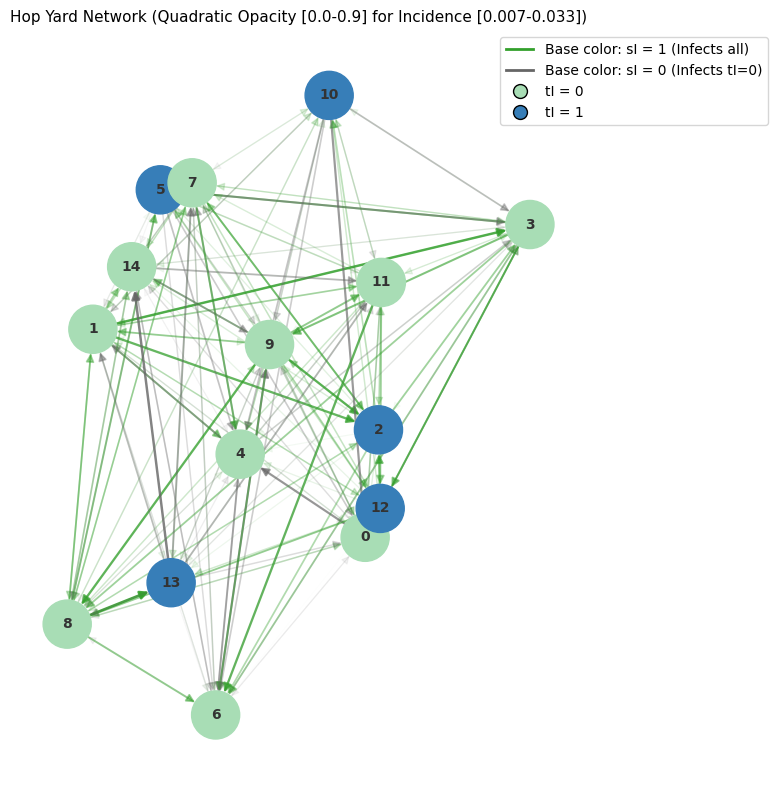

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba # Import for color conversion
import math # Needed for checking isnan

# --- create_elegant_hop_network function remains the same ---
def create_elegant_hop_network(num_nodes=10, seed=40, plants_per_yard=400, infection_prob=0.02):
    """
    Creates a directed hop yard network with disease strain (sI)
    and plant variety (tI) dependencies, calculating edge weights based on
    simulated disease incidence.

    Args:
        num_nodes (int): The number of hop yards (nodes) in the network.
        seed (int): Seed for random number generation to ensure reproducibility
                    of node attributes and graph structure potential.
        plants_per_yard (int): Number of plants in each yard.
        infection_prob (float): Probability of a single plant being infected (p for binomial).

    Returns:
        networkx.DiGraph: The generated directed graph with edge weights.
    """

    np.random.seed(seed) # Seed for node attributes and overall structure logic

    # Generate sI and tI arrays (50% 0, 50% 1)
    sI = np.random.choice([0, 1], size=num_nodes, p=[0.5, 0.5])
    tI = np.random.choice([0, 1], size=num_nodes, p=[0.5, 0.5])

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes
    for i in range(num_nodes):
        G.add_node(i, sI=sI[i], tI=tI[i])

    # Add edges based on infection rules and calculate weights
    total_plants_between_two_yards = 2 * plants_per_yard
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                # Check if an edge should exist based on infection rules
                if G.nodes[i]['sI'] == 1 or (G.nodes[i]['sI'] == 0 and G.nodes[j]['tI'] == 0):
                    # Simulate disease incidence for the connected pair
                    infections_i = np.random.binomial(n=plants_per_yard, p=infection_prob)
                    infections_j = np.random.binomial(n=plants_per_yard, p=infection_prob)
                    total_infections = infections_i + infections_j

                    # Calculate weight as total incidence across the pair
                    if total_plants_between_two_yards > 0:
                         weight = total_infections / float(total_plants_between_two_yards)
                    else:
                         weight = 0.0
                    weight = max(0.0, min(1.0, weight)) # Clamp weight

                    G.add_edge(i, j, weight=weight) # Add edge with calculated weight

    return G


def visualize_elegant_hop_network(G, layout_seed=None):
    """
    Visualizes the hop yard network with random node positioning and
    edge opacity QUADRATICALLY scaled between 0.0 and 0.9 based on the
    min/max observed disease incidence (weight).

    Args:
        G (networkx.DiGraph): The hop yard network graph with 'weight' attribute on edges.
        layout_seed (int, optional): Seed for the random layout algorithm for reproducibility.
                                     Defaults to None (non-reproducible layout).
    """
    if not G.nodes:
        print("Graph has no nodes. Cannot visualize.")
        return
    if not G.edges:
        print("Graph has no edges. Visualizing nodes only.")
        # Fallback to just drawing nodes if there are no edges
        pos = nx.random_layout(G, seed=layout_seed)
        node_colors = ['#a8ddb5' if G.nodes[i]['tI'] == 0 else '#377eb8' for i in G.nodes]
        node_sizes = [1200 for _ in G.nodes]
        plt.figure(figsize=(10, 10), dpi=100)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
        labels = {i: str(i) for i in G.nodes}
        nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold', font_color='#333333')
        plt.title("Hop Yard Network (Nodes Only - No Edges)", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        return

    # --- Calculate min/max weights for scaling ---
    all_weights = [data.get('weight', 0.0) for u, v, data in G.edges(data=True)]
    min_weight = min(all_weights)
    max_weight = max(all_weights)
    weight_range = max_weight - min_weight

    print(f"Edge weights range from {min_weight:.4f} to {max_weight:.4f}. Applying quadratic scaling to [0.0, 0.9] alpha.")

    # --- Use random layout ---
    pos = nx.random_layout(G, seed=layout_seed)

    # Node colors and sizes
    node_colors = ['#a8ddb5' if G.nodes[i]['tI'] == 0 else '#377eb8' for i in G.nodes]
    node_sizes = [1200 for _ in G.nodes]

    # --- Edge styling with QUADRATICALLY SCALED opacity ---
    edge_rgba_colors = []
    base_color_sI1_rgba = to_rgba('#33a02c')
    base_color_sI0_rgba = to_rgba('#666666')
    edge_widths = []

    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 0.0)

        # --- Apply Quadratic Min-Max Scaling to [0.0, 0.9] range ---
        alpha = 0.0 # Default alpha
        if weight_range > 1e-9: # Avoid division by zero if all weights are the same
            # Normalize weight to [0, 1]
            normalized_weight = (weight - min_weight) / weight_range
            normalized_weight = max(0.0, min(1.0, normalized_weight)) # Clamp normalization
            # Apply quadratic scaling and map to [0, 0.9]
            alpha = (normalized_weight ** 2) * 0.9
        elif max_weight > 1e-9: # Handle case where all weights are the same and non-zero
             alpha = 0.9 # Assign max opacity (as it's the max observed value)
        # else: # Handle case where all weights are zero (or near zero)
        #   alpha remains 0.0 (default)

        # Clamp final alpha just to be safe
        alpha = max(0.0, min(0.9, alpha))
        # --- End Scaling ---

        edge_widths.append(0.8 + alpha * 1.2) # Optional: Scale width based on scaled alpha

        if G.nodes[u]['sI'] == 1:
            base_color = base_color_sI1_rgba
        else:
            base_color = base_color_sI0_rgba

        # Create RGBA tuple with the *scaled* alpha
        edge_rgba_colors.append((base_color[0], base_color[1], base_color[2], alpha))

    arrowstyles = [ '-|>' for _ in G.edges]

    # Draw the network
    plt.figure(figsize=(8, 8), dpi=100)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color=edge_rgba_colors,
                           arrowstyle=arrowstyles,
                           width=edge_widths,
                           arrowsize=12,
                           node_size=node_sizes)

    # Add labels to nodes
    labels = {i: str(i) for i in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold', font_color='#333333')

    # Create custom legend elements
    legend_elements = [
        plt.Line2D([0], [0], color='#33a02c', lw=2, label='Base color: sI = 1 (Infects all)'),
        plt.Line2D([0], [0], color='#666666', lw=2, label='Base color: sI = 0 (Infects tI=0)'),
        plt.Line2D([0], [0], marker='o', markersize=10, markerfacecolor='#a8ddb5', markeredgecolor='black', label='tI = 0', linestyle='None'),
        plt.Line2D([0], [0], marker='o', markersize=10, markerfacecolor='#377eb8', markeredgecolor='black', label='tI = 1', linestyle='None'),
    ]

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1))

    plt.title(f"Hop Yard Network (Quadratic Opacity [0.0-0.9] for Incidence [{min_weight:.3f}-{max_weight:.3f}])", fontsize=11) # Updated title
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# --- Main execution block remains the same ---
if __name__ == "__main__":
    # --- Parameters ---
    N_YARDS = 15        # Number of hop yards
    PLANTS_PER_YARD = 400 # Plants in each yard
    INFECTION_PROB = 0.02 # Binomial probability for infection in a yard
    RANDOM_SEED = 42    # Seed for reproducibility of graph generation
    LAYOUT_SEED = 123   # Separate seed for layout reproducibility

    hop_network = create_elegant_hop_network(
        num_nodes=N_YARDS,
        seed=RANDOM_SEED,
        plants_per_yard=PLANTS_PER_YARD,
        infection_prob=INFECTION_PROB
    )
    visualize_elegant_hop_network(hop_network, layout_seed=LAYOUT_SEED)

    # Example Analysis (optional)
    # print("\nEdge weights:")
    # for u, v, data in hop_network.edges(data=True):
    #     print(f"  Edge ({u} -> {v}): Weight = {data['weight']:.4f}")

In [50]:
degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])

AttributeError: 'DegreeView' object has no attribute 'items'

In [48]:
degree_centrality_df

Node  Centrality
0       0    5.168172
1       1   53.135463
2       2   54.063512
3       3   63.742990
4       4   72.609133
..    ...         ...
145   145   94.724858
146   146   98.600106
147   147   75.337819
148   148   37.625959
149   149    8.350072

[150 rows x 2 columns]

In [ ]:
de


Performing KMeans clustering with k=10...
Added 'Cluster' column to 'coord' DataFrame.

Summed Weighted Degree Centrality per Cluster:
Cluster
0     678.414920
1     894.807568
2     791.495369
3    1165.218638
4     477.026108
5     847.095518
6     652.683718
7     561.791132
8     610.536389
9     763.217852
Name: Centrality, dtype: float64

Yards per cluster:
Cluster
0    13
1    15
2    17
3    22
4    15
5    17
6    11
7    13
8    10
9    17
dtype: int64

Generating Folium map with all yards colored by cluster and legend (including counts)...

Map with all clusters and counts saved to all_clusters_map_with_counts_year_2017.html

--- Clustering and Mapping Section Finished ---


C:\Users\joshf\AppData\Local\Temp\ipykernel_30956\3988613558.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', k_clusters)


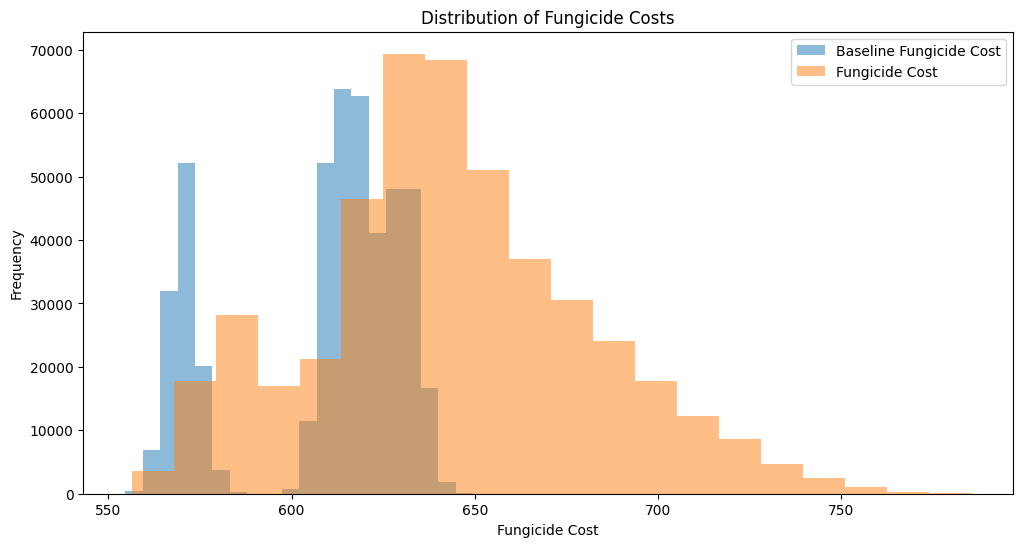

In [92]:
# Plot histogram with df['Mean Baseline Fungicide Cost'].hist() and df['Mean Fungicide Cost'].hist()
plt.figure(figsize=(12, 6))
plt.hist(df['Mean Baseline Fungicide Cost'], bins=20, alpha=0.5, label='Baseline Fungicide Cost')
plt.hist(df['Mean Fungicide Cost'], bins=20, alpha=0.5, label='Fungicide Cost')
plt.xlabel('Fungicide Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Fungicide Costs')
plt.legend()
plt.show()

<Axes: >

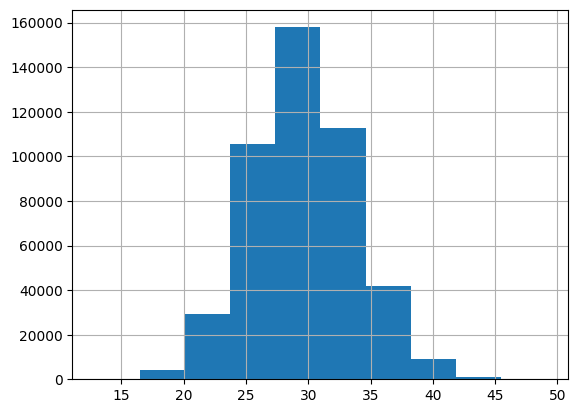

In [86]:
df['Mean Baseline Fungicide Cost May'].hist()

<Axes: >

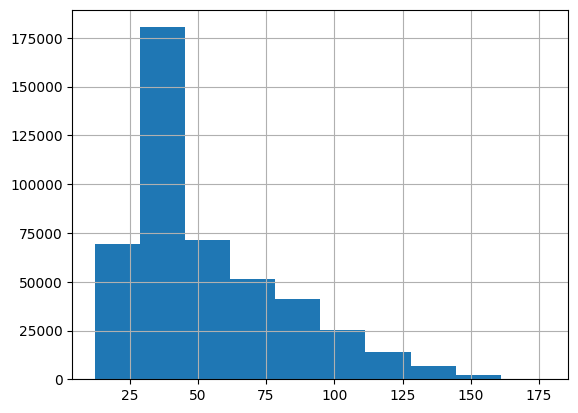

In [87]:
df['Mean Fungicide Cost May'].hist()

In [79]:
df['Mean Sprays in June'].describe()

count    462000.000000
mean          1.568172
std           0.012291
min           1.560017
25%           1.560178
50%           1.561635
75%           1.575791
max           1.609332
Name: Mean Sprays in June, dtype: float64

In [78]:
df['Mean Baseline Sprays in June'].describe()

count    4.620000e+05
mean     1.560017e+00
std      5.661055e-16
min      1.560017e+00
25%      1.560017e+00
50%      1.560017e+00
75%      1.560017e+00
max      1.560017e+00
Name: Mean Baseline Sprays in June, dtype: float64

<Axes: >

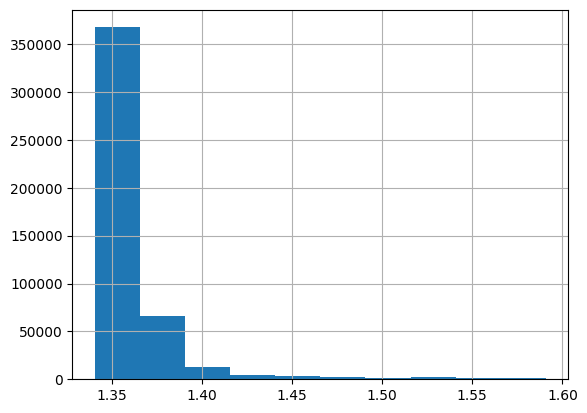

In [89]:
df['Mean Sprays in July'].hist()

<Axes: >

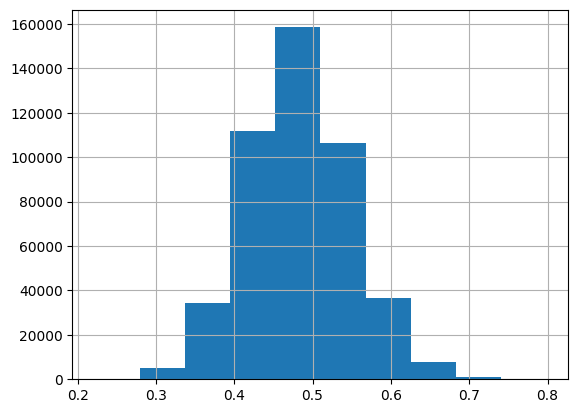

In [ ]:
df['Mean Baseline Sprays in May'].hist()

In [ ]:
np.mean(disease_incidence_may_list[i], axis=1)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (462000,) + inhomogeneous part.

In [61]:
test_list1 = []

for i in range(len(disease_incidence_may_list)):
    
    test_list1.append(np.mean(disease_incidence_may_list[i], axis=0)[0])
    
    
test_list2 = []

for i in range(len(disease_incidence_jun_list)):
    
    test_list2.append(np.mean(disease_incidence_jun_list[i], axis=0)[0])
    
test_list3 = []

for i in range(len(disease_incidence_jul_list)):
        
        test_list3.append(np.mean(disease_incidence_jul_list[i], axis=0)[0])

In [63]:
len(test_list1)

462000

In [2]:
#import data from '../data/processed/simulations/simulations_jan31_2.parquet'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../data/processed/simulations/simulations_jan31_2.parquet')

In [5]:
df.columns

Index(['Year', 'V6 Percent', 'Initial Probability', 'Quantile',
       'Mean Profit Percent Change', 'Sprays in May', 'Market Demand',
       'Simulation', 'Disease Incidence May', 'Disease Incidence June',
       'Disease Incidence July', 'Mean Sprays in May', 'Mean Sprays in June',
       'Mean Sprays in July', 'Mean Sprays in Late Season',
       'Mean Baseline Sprays in May', 'Mean Baseline Sprays in June',
       'Mean Baseline Sprays in July', 'Mean Baseline Sprays in Late Season',
       'Mean Fungicide Cost Early Season', 'Mean Fungicide Cost May',
       'Mean Fungicide Cost June', 'Mean Fungicide Cost July',
       'Mean Fungicide Cost Late Season', 'Mean Fungicide Cost',
       'Mean Baseline Fungicide Cost May', 'Mean Baseline Fungicide Cost June',
       'Mean Baseline Fungicide Cost July',
       'Mean Baseline Fungicide Cost Late Season',
       'Mean Baseline Fungicide Cost', 'Mean Price', 'Mean Yield',
       'Mean Baseline Price', 'Mean Baseline Yield', 'Mean Cone Col

In [6]:
# drop 'Market Demand' column
df = df.drop('Market Demand', axis=1)


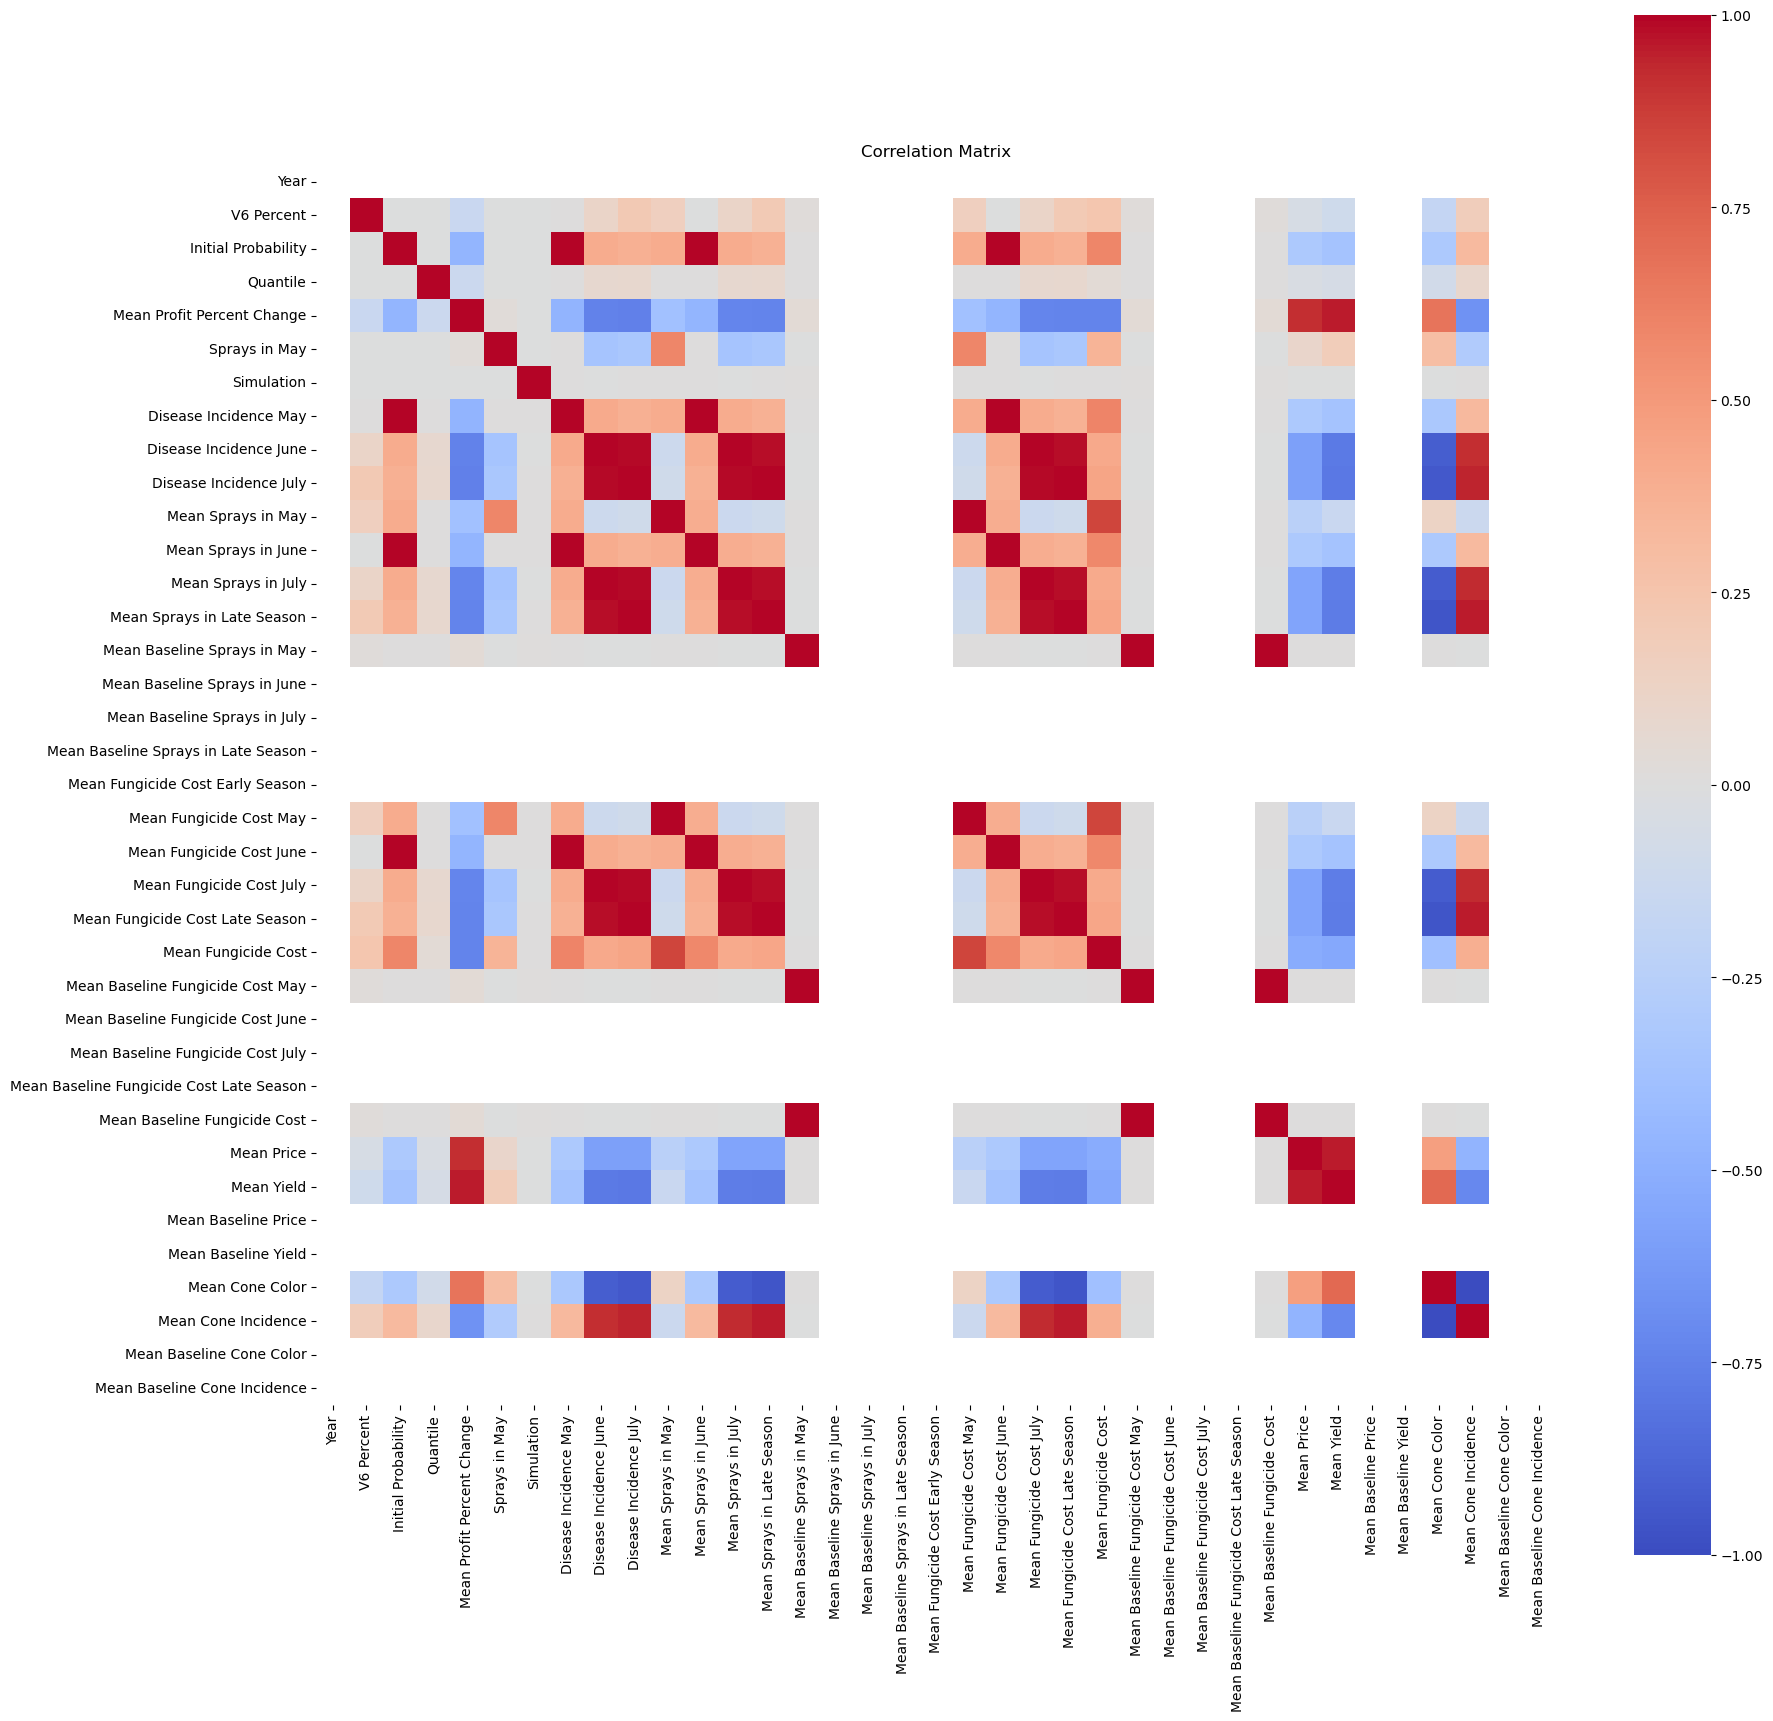

In [10]:
# plot correlation matrix without annotation labels
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=False, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [64]:
# Create a DataFrame from the lists
df = pd.DataFrame({
    'Year': year_list,
    'V6 Percent': V6_percent_list,
    'Initial Probability': initial_prob_list,
    'Quantile': quantile_list,
    'Mean Profit Percent Change': mean_profit_percent_change_list,
    'Sprays in May': sprays_in_May_list,
    'Market Demand': market_demand_list,
    'Simulation': simulation_list,
    'Disease Incidence May': test_list1,
    'Disease Incidence June': test_list2,
    'Disease Incidence July': test_list3,
    'Mean Sprays in May': mean_sprays_may_list,
    'Mean Sprays in June': mean_sprays_jun_list,
    'Mean Sprays in July': mean_sprays_jul_list,
    'Mean Sprays in Late Season': mean_sprays_late_list,
    'Mean Baseline Sprays in May': mean_sprays_may_baseline_list,
    'Mean Baseline Sprays in June': mean_sprays_jun_baseline_list,
    'Mean Baseline Sprays in July': mean_sprays_jul_baseline_list,
    'Mean Baseline Sprays in Late Season': mean_sprays_late_baseline_list,
    'Mean Fungicide Cost Early Season': mean_fung_cost_early_list,
    'Mean Fungicide Cost May': mean_fung_cost_may_list,
    'Mean Fungicide Cost June': mean_fung_cost_jun_list,
    'Mean Fungicide Cost July': mean_fung_cost_jul_list,
    'Mean Fungicide Cost Late Season': mean_fung_cost_late_list,
    'Mean Fungicide Cost': mean_fung_cost_list,
    'Mean Baseline Fungicide Cost May': mean_baseline_fung_cost_may_list,
    'Mean Baseline Fungicide Cost June': mean_baseline_fung_cost_jun_list,
    'Mean Baseline Fungicide Cost July': mean_baseline_fung_cost_jul_list,
    'Mean Baseline Fungicide Cost Late Season': mean_baseline_fung_cost_late_list,
    'Mean Baseline Fungicide Cost': mean_baseline_fung_cost_list,
    'Mean Price': mean_price_list,
    'Mean Yield': mean_yield_list,
    'Mean Baseline Price': mean_baseline_price_list,
    'Mean Baseline Yield': mean_baseline_yield_list,
    'Mean Cone Color': mean_cone_color_list,
    'Mean Cone Incidence': mean_cone_incidence_list,
    'Mean Baseline Cone Color': mean_baseline_cone_color_list,
    'Mean Baseline Cone Incidence': mean_baseline_cone_incidence_list
})

In [65]:
df.head()

Year  V6 Percent  Initial Probability  Quantile  \
0  2014         0.0              0.00001       0.2   
1  2014         0.0              0.00001       0.2   
2  2014         0.0              0.00001       0.2   
3  2014         0.0              0.00001       0.2   
4  2014         0.0              0.00001       0.2   

   Mean Profit Percent Change  Sprays in May Market Demand  Simulation  \
0                   -0.045125              0           low           0   
1                   -0.068266              0      moderate           0   
2                   -0.150354              0          high           0   
3                   -0.017113              1           low           0   
4                   -0.025887              1      moderate           0   

   Disease Incidence May  Disease Incidence June  ...  \
0                    0.0                     0.0  ...   
1                    0.0                     0.0  ...   
2                    0.0                     0.0  ...   
3                    0.0                     0.0  ...   
4                    0.0                     0.0  ...   

   Mean Baseline Fungicide Cost Late Season  Mean Baseline Fungicide Cost  \
0                                279.924016                    617.797554   
1                                279.924016                    617.797554   
2                                279.924016                    617.797554   
3                                279.924016                    621.313554   
4                                279.924016                    621.313554   

   Mean Price   Mean Yield  Mean Baseline Price  Mean Baseline Yield  \
0    4.577412  4669.576165             4.577412          4669.576165   
1    6.175294  4669.576165             6.175294          4669.576165   
2    7.913588  4669.576165             7.913588          4669.576165   
3    4.577412  4669.576165             4.577412          4669.576165   
4    6.175294  4669.576165             6.175294          4669.576165   

   Mean Cone Color  Mean Cone Incidence  Mean Baseline Cone Color  \
0         9.882542             0.016213                  9.882542   
1         9.882542             0.016213                  9.882542   
2         9.882542             0.016213                  9.882542   
3         9.882542             0.016213                  9.882542   
4         9.882542             0.016213                  9.882542   

   Mean Baseline Cone Incidence  
0                      0.016213  
1                      0.016213  
2                      0.016213  
3                      0.016213  
4                      0.016213  

[5 rows x 38 columns]

In [66]:
# Save as parquet
df.to_parquet('../data/processed/simulations/simulations_dec6.parquet', index=False)

In [72]:
df.columns

Index(['Year', 'V6 Percent', 'Initial Probability', 'Quantile',
       'Mean Profit Percent Change', 'Sprays in May', 'Market Demand',
       'Simulation', 'Disease Incidence May', 'Disease Incidence June',
       'Disease Incidence July', 'Mean Sprays in May', 'Mean Sprays in June',
       'Mean Sprays in July', 'Mean Sprays in Late Season',
       'Mean Baseline Sprays in May', 'Mean Baseline Sprays in June',
       'Mean Baseline Sprays in July', 'Mean Baseline Sprays in Late Season',
       'Mean Fungicide Cost Early Season', 'Mean Fungicide Cost May',
       'Mean Fungicide Cost June', 'Mean Fungicide Cost July',
       'Mean Fungicide Cost Late Season', 'Mean Fungicide Cost',
       'Mean Baseline Fungicide Cost May', 'Mean Baseline Fungicide Cost June',
       'Mean Baseline Fungicide Cost July',
       'Mean Baseline Fungicide Cost Late Season',
       'Mean Baseline Fungicide Cost', 'Mean Price', 'Mean Yield',
       'Mean Baseline Price', 'Mean Baseline Yield', 'Mean Cone Col

In [14]:
disease_incidence_may_list

[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [68]:
# save as parquet
df.to_parquet('../data/processed/simulations/simulations_dec5.parquet', index=False)

# save as parquet
yard_df.to_parquet('../data/processed/simulations/yard_data_dec5.parquet', index=False)

In [ ]:


import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define parameters
year = years[0]
market_demand = markets[0]

# Read and filter the data
file_name = '../data/processed/simulations/simulations_nov5.csv'
df_profit_all = pd.read_csv(file_name)
df_profit_all = df_profit_all[
    (df_profit_all['Year'] == year) & 
    (df_profit_all['Market Demand'] == market_demand)
]

# Convert 'Quantile' to string type for consistent labeling
df_profit_all['Quantile'] = df_profit_all['Quantile'].astype(str)

# Get sorted unique V6 Percent and Initial Probability values
unique_v6_percent = sorted(df_profit_all['V6 Percent'].unique())
unique_init_prob = sorted(df_profit_all['Initial Probability'].unique())

# **Format initial probabilities without trailing zeros**
def format_prob(prob, decimal_places=5):
    formatted = f"{prob:.{decimal_places}f}".rstrip('0').rstrip('.')
    return formatted if formatted else '0'

unique_init_prob_labels = [format_prob(prob) for prob in unique_init_prob]

# Define the grid size
n_rows = len(unique_v6_percent)
n_cols = len(unique_init_prob)

# Create subplot titles as empty strings
subplot_titles = [''] * (n_rows * n_cols)

# Create the figure with subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.02,
    vertical_spacing=0.02,
    shared_xaxes=True,
    shared_yaxes=True,
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# Determine global color scale limits
v_min = df_profit_all['Mean Profit Percent Change'].min()
v_max = df_profit_all['Mean Profit Percent Change'].max()

# Add heatmaps to subplots
for _, row_data in df_profit_all[['V6 Percent', 'Initial Probability']].drop_duplicates().iterrows():
    v6_value = row_data['V6 Percent']
    init_prob_value = row_data['Initial Probability']

    # Filter the dataframe for the current combination
    df_filtered = df_profit_all[
        (df_profit_all['V6 Percent'] == v6_value) &
        (df_profit_all['Initial Probability'] == init_prob_value)
    ]

    # Pivot the data for heatmap
    pivot_profit = df_filtered.pivot_table(
        values='Mean Profit Percent Change',
        index='Quantile',
        columns='Sprays in May',
        aggfunc="mean"
    ).sort_index(axis=1)

    # Get x and y axes labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist()

    # Determine subplot position
    v6_index = unique_v6_percent.index(v6_value)
    init_prob_index = unique_init_prob.index(init_prob_value)
    row = v6_index + 1
    col = init_prob_index + 1

    # Add heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=pivot_profit.values,
            x=x_labels,
            y=y_labels,
            colorscale='Viridis',
            zmin=v_min,
            zmax=v_max,
            coloraxis='coloraxis',
            showscale=False,
            xgap=0,
            ygap=0,
            hoverongaps=False
        ),
        row=row,
        col=col
    )

# Define Dracula color palette
dracula_bg = '#282a36'
dracula_font = '#f8f8f2'

# Update layout
fig.update_layout(
    template=None,
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        text=f'Figure 2: Relative Change in Profit given {market_demand.capitalize()} Market Demand in {year}',
        font=dict(
            color=dracula_font,
            size=18
        ),
        x=0.5,
        y=0.96,
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(l=80, r=180, t=100, b=80),  # Increased top margin to accommodate new label
    coloraxis=dict(
        colorscale='Viridis',
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title='Profit % Change',
            titleside='right',
            tickfont=dict(size=10),
            len=1.05,
            y=0.5,
            x=1.08,
            thickness=10
        )
    )
)

# Add "Initial Probability of Disease" label at the top center
fig.add_annotation(
    dict(
        text="Initial Probability of Disease",
        x=0.5,
        y=1.15,  # Positioned slightly above the p₀ labels
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,  # Adjust font size as needed
            color=dracula_font
        ),
        align='center',
        xanchor='center'
    )
)

# Add initial probability labels with decimal notation without trailing zeros
for idx, init_prob_label in enumerate(unique_init_prob_labels):
    x_pos = (idx + 1 - 0.5) / n_cols  # Centered above each column
    fig.add_annotation(
        dict(
            text=f"p₀ = {init_prob_label}",
            x=x_pos,
            y=1.06,  # Positioned below the new "Initial Probability of Disease" label
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=8,  # Adjust font size as needed
                color=dracula_font
            ),
            align='center',
            xanchor='center'
        )
    )

# Add row labels (% V6) at the right of each row
for idx, v6_value in enumerate(unique_v6_percent):
    y_pos = 1 - ((idx + 1 - 0.5) / n_rows)
    fig.add_annotation(
        dict(
            text=f"{int(v6_value * 100)}% V6",
            x=1.08,
            y=y_pos,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=8,
                color=dracula_font
            ),
            align='center',
            yanchor='middle'
        )
    )

# Add shared x-axis title
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=-0.15,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=dracula_font
        ),
        align='center'
    )
)

# Add shared y-axis title
fig.add_annotation(
    dict(
        text="Percentile of Dispersal-Centrality",
        x=-0.08,
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=dracula_font
        ),
        align='center'
    )
)

# Update hover template
fig.update_traces(
    hovertemplate=
    'Sprays in May: %{x}<br>' +
    'Percentile: %{y}<br>' +
    'Profit % Change: %{z:.2f}%<extra></extra>'
)

# Show the figure
fig.show()

In [50]:
profit_function_0(infections=np.zeros((N,1)), variety=variety_array, demand='high')

array([[-10354.75746594],
       [ -5898.31971913],
       [ -5464.77340503],
       [-10354.75746594],
       [ -5464.77340503],
       [  2459.50538722],
       [-14832.68529698],
       [-15266.23161109],
       [  2893.05170133],
       [  2426.32013146],
       [-10821.4890358 ],
       [ -5497.95866078],
       [  2859.86644557],
       [  2859.86644557],
       [-10354.75746594],
       [  2859.86644557],
       [ -5931.50497489],
       [ -5931.50497489],
       [-14832.68529698],
       [-15266.23161109],
       [  2530.98268012],
       [ -5893.21293775],
       [-15628.3006323 ],
       [  2898.15848271],
       [-10316.4654288 ],
       [ -5426.48136788],
       [  2898.15848271],
       [-14794.39325984],
       [-10316.4654288 ],
       [-14794.39325984],
       [  2931.34373847],
       [-10750.01174291],
       [-10804.38303454],
       [ -5914.39897363],
       [ -5480.85265952],
       [ -5480.85265952],
       [ -5480.85265952],
       [-14848.76455148],
       [-103

In [47]:
profit_array_0

array([[-10354.75746594],
       [ -5898.31971913],
       [ -5464.77340503],
       [-10354.75746594],
       [ -5464.77340503],
       [  2459.50538722],
       [-14832.68529698],
       [-15266.23161109],
       [  2893.05170133],
       [  2426.32013146],
       [-10821.4890358 ],
       [ -5497.95866078],
       [  2859.86644557],
       [  2859.86644557],
       [-10354.75746594],
       [  2859.86644557],
       [ -5931.50497489],
       [ -5931.50497489],
       [-14832.68529698],
       [-15266.23161109],
       [  2530.98268012],
       [ -5893.21293775],
       [-15628.3006323 ],
       [  2898.15848271],
       [-10316.4654288 ],
       [ -5426.48136788],
       [  2898.15848271],
       [-14794.39325984],
       [-10316.4654288 ],
       [-14794.39325984],
       [  2931.34373847],
       [-10750.01174291],
       [-10804.38303454],
       [ -5914.39897363],
       [ -5480.85265952],
       [ -5480.85265952],
       [ -5480.85265952],
       [-14848.76455148],
       [-103

In [45]:
sprays_may(np.zeros((N,1)), lambda_may_0).mean()

np.float64(0.47540983606557374)

In [ ]:
sprays_may(0, lambda_may_0)

1

In [42]:
lambda_may

10

In [43]:
lambda_may_0

np.float64(0.48333333333333334)

In [39]:
total_cost_0

array([[43796.997453  ],
       [43796.997453  ],
       [43796.997453  ],
       [43796.997453  ],
       [43796.997453  ],
       [43796.997453  ],
       [43796.997453  ],
       [43796.997453  ],
       [43796.997453  ],
       [43830.18270876],
       [43830.18270876],
       [43830.18270876],
       [43830.18270876],
       [43830.18270876],
       [43796.997453  ],
       [43830.18270876],
       [43830.18270876],
       [43830.18270876],
       [43796.997453  ],
       [43796.997453  ],
       [43725.52016011],
       [43791.89067162],
       [43725.52016011],
       [43791.89067162],
       [43758.70541586],
       [43758.70541586],
       [43791.89067162],
       [43758.70541586],
       [43758.70541586],
       [43758.70541586],
       [43758.70541586],
       [43758.70541586],
       [43813.0767075 ],
       [43813.0767075 ],
       [43813.0767075 ],
       [43813.0767075 ],
       [43813.0767075 ],
       [43813.0767075 ],
       [43813.0767075 ],
       [43813.0767075 ],


In [40]:
total_cost - total_cost_0

array([[ 656.21893264],
       [ 595.754372  ],
       [ 764.74422922],
       [ 583.09144856],
       [ 583.08414899],
       [ 595.54629365],
       [ 716.73279634],
       [ 656.22623867],
       [ 716.57167592],
       [ 643.68645832],
       [ 717.28169423],
       [ 596.1467992 ],
       [ 583.14933831],
       [ 643.68415165],
       [ 704.19290829],
       [ 594.75633716],
       [ 655.37690703],
       [ 655.16574282],
       [ 595.38382237],
       [ 656.10265669],
       [ 656.37092625],
       [ 583.04330992],
       [ 643.58766435],
       [1213.1762671 ],
       [1324.7114055 ],
       [ 595.7118486 ],
       [1569.12196641],
       [ 595.76306367],
       [1326.13059026],
       [1258.62498492],
       [1094.73137586],
       [1639.10426445],
       [ 656.69887187],
       [ 583.25442978],
       [ 596.35131463],
       [1029.79159651],
       [ 583.10725501],
       [1198.94751935],
       [1036.40371294],
       [ 656.6065317 ],
       [ 635.36250784],
       [ 583.008

In [32]:
total_cost

array([[44453.08757438],
       [44513.69285042],
       [44392.51808312],
       [44380.06515151],
       [44392.48912217],
       [44440.60649383],
       [44380.06221959],
       [44380.06937976],
       [44452.96848327],
       [44413.39503204],
       [44473.92759883],
       [44426.0597782 ],
       [44425.95097251],
       [44473.92326977],
       [44440.61554557],
       [44485.34195174],
       [44424.88320866],
       [44413.18081088],
       [44501.1509934 ],
       [44453.052015  ],
       [44369.3450073 ],
       [44507.9766196 ],
       [44369.10899851],
       [44624.56425671],
       [44841.25653405],
       [44414.68340961],
       [44747.02626017],
       [44341.90528364],
       [45146.94794202],
       [45201.9332005 ],
       [44594.06307702],
       [45094.03356913],
       [44409.03898761],
       [44517.33253379],
       [44409.23453875],
       [45450.99611129],
       [44408.85699654],
       [45009.3761761 ],
       [44789.51223254],
       [44530.11059491],


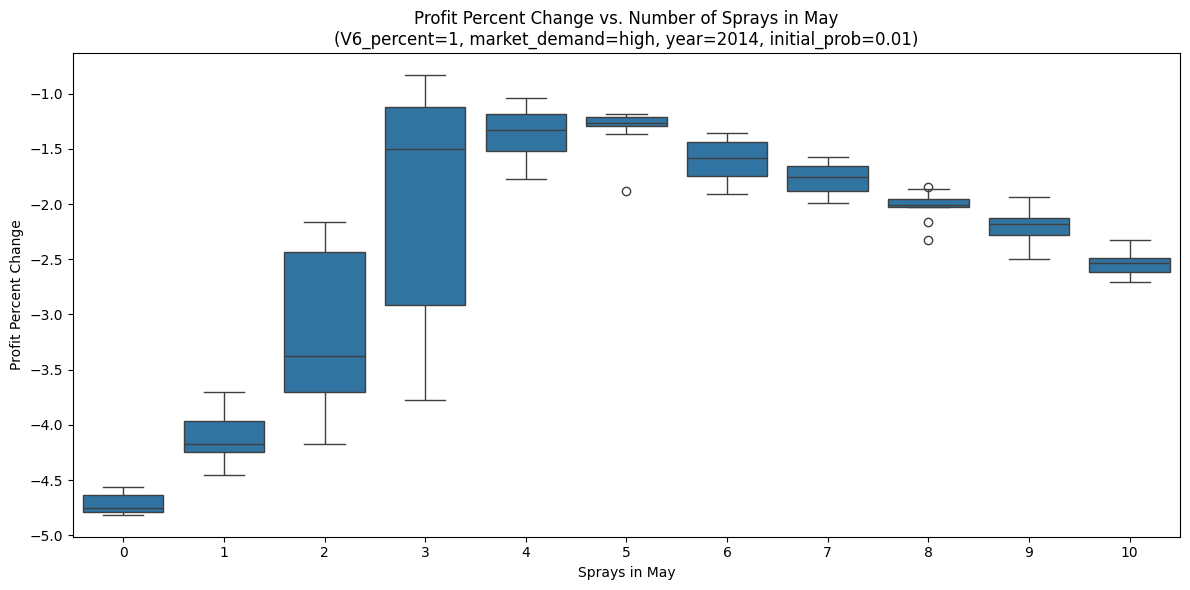

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

year = years[0]
market_demand = markets[0]
V6_percent = 1
initial_prob = 0.01
quantile = '1.0'

# # Read the single file
# file_name = '../data/processed/simulations/percent_change/profit_percent_change_simulations_power_oct25.csv'
# df_profit_all = pd.read_csv(file_name)

# Filter the data based on the specified conditions
df_filtered = df_profit_all[
    (df_profit_all['Year'] == year) & 
    (df_profit_all['Market Demand'] == market_demand) &
    (df_profit_all['V6 Percent'] == V6_percent) &
    (df_profit_all['Initial Probability'] == initial_prob) &
    (df_profit_all['Quantile'] == quantile)
]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create the box plot
sns.boxplot(x='Sprays in May', y='Mean Profit Percent Change', data=df_filtered, ax=ax)

# Set the order of sprays from 0 to 12
#ax.set_xticklabels(range(13))

# Set labels and title
ax.set_xlabel('Sprays in May')
ax.set_ylabel('Profit Percent Change')
ax.set_title(f'Profit Percent Change vs. Number of Sprays in May\n(V6_percent={V6_percent}, market_demand={market_demand}, year={year}, initial_prob={initial_prob})')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [292]:
fung_cost_jul

array([[191.17493998],
       [186.72321363],
       [191.17493998],
       [186.7358494 ],
       [186.7456705 ],
       [191.17493998],
       [191.17493998],
       [186.5763618 ],
       [191.17493998],
       [186.57559643],
       [191.17493998],
       [186.5818148 ],
       [186.61184482],
       [186.57905319],
       [186.68258707],
       [186.83004688],
       [191.17493998],
       [191.17493998],
       [191.17493998],
       [191.17493998],
       [191.17493998],
       [186.71094117],
       [186.59145515],
       [186.56145363],
       [191.17493998],
       [191.17493998],
       [186.53000864],
       [191.17493998],
       [191.17493998],
       [191.17493998],
       [186.83643509],
       [186.71804873],
       [186.49393808],
       [186.48973259],
       [191.17493998],
       [186.49537271],
       [191.17493998],
       [191.17493998],
       [186.49415102],
       [191.17493998],
       [186.50569038],
       [186.50636753],
       [186.67075327],
       [191

In [286]:
fung_cost_may

array([[   0.        ],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [  58.01399155],
       [   0.        ],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [   0.        ],
       [  58.01399155],
       [   0.        ],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [   0.        ],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [   0.        ],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [1102.26583952],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [ 464.11193243],
       [  58.01399155],
       [ 754.1818902 ],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [   0.        ],
       [ 116.02798311],
       [   0.        ],
       [   0.        ],
       [   0.        ],
       [  58.01399155],
       [   0.        ],
       [   0.        ],
       [  58.013

In [285]:
fung_cost

array([[ 609.82660397],
       [ 667.709588  ],
       [ 593.25267955],
       [ 609.88220119],
       [ 651.25762553],
       [ 593.22582736],
       [ 651.27544999],
       [ 593.28697542],
       [ 593.23121927],
       [ 593.31398306],
       [ 651.29658847],
       [ 610.00148863],
       [ 667.05904582],
       [ 609.48272818],
       [ 593.23928166],
       [ 593.26137607],
       [ 667.85160421],
       [ 605.49408394],
       [ 593.03986486],
       [ 593.01034367],
       [ 667.17442148],
       [ 593.2590129 ],
       [ 656.72489392],
       [1712.30433632],
       [ 666.45509932],
       [ 607.66132896],
       [ 660.93035165],
       [1070.57162771],
       [ 665.48703114],
       [1361.31590425],
       [ 651.2593555 ],
       [ 593.13649078],
       [ 607.62874278],
       [ 606.16621361],
       [ 723.44110033],
       [ 593.01397721],
       [ 606.96402034],
       [ 593.03001621],
       [ 651.07814829],
       [ 607.62116168],
       [ 607.06937338],
       [ 665.170

In [283]:
y_2

array([[57.47542783],
       [10.08431959],
       [57.5500554 ],
       [10.31573043],
       [55.89669825],
       [57.32892991],
       [59.93520764],
       [10.0980493 ],
       [56.64971754],
       [10.11533088],
       [58.06189961],
       [10.28577991],
       [57.62141718],
       [10.15118509],
       [10.04078049],
       [53.51269348],
       [10.22934452],
       [ 8.98588715],
       [ 8.92601217],
       [36.58049725],
       [53.80398304],
       [60.57554009],
       [40.64639032],
       [50.39500362],
       [55.49255335],
       [51.70437205],
       [ 9.13549782],
       [10.10404478],
       [ 9.84501142],
       [44.55391872],
       [10.55213352],
       [47.46120887],
       [42.31658501],
       [38.94071128],
       [ 9.07881335],
       [ 8.84846053],
       [41.17571026],
       [41.22937004],
       [ 9.01877455],
       [ 9.04119162],
       [ 8.87897717],
       [ 8.88245643],
       [ 9.1725606 ],
       [ 8.86400067],
       [ 9.08341049],
       [ 9

In [279]:
sprays_0

array([[ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 4.],
       [ 0.],
       [ 0.],
       [ 0.],
       [12.],
       [ 2.],
       [17.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 4.],
       [ 0.],
       [ 0.],
       [ 7.],
       [ 1.],
       [ 0.],
      

In [ ]:
early_fung_cost + fung_cost_may + fung_cost_jun + fung_cost_jul + fung_cost_late

In [263]:
prob('jun-jul', 400, 100000) * n

array([[23.23516185],
       [ 8.06388628],
       [ 8.06388628],
       [ 8.06388628],
       [23.23516185],
       [23.23516185],
       [ 8.06388628],
       [23.23516185],
       [ 8.06388628],
       [23.23516185],
       [23.23516185],
       [ 8.06388628],
       [23.23516185],
       [ 8.06388628],
       [23.23516185],
       [ 8.06388628],
       [ 8.06388628],
       [ 8.06388628],
       [ 8.06388628],
       [23.23516185],
       [23.23516185],
       [ 8.06388628],
       [ 8.06388628],
       [ 8.06388628],
       [23.23516185],
       [23.23516185],
       [23.23516185],
       [23.23516185],
       [ 8.06388628],
       [23.23516185],
       [23.23516185],
       [23.23516185],
       [23.23516185],
       [ 8.06388628],
       [ 8.06388628],
       [23.23516185],
       [23.23516185],
       [23.23516185],
       [ 8.06388628],
       [23.23516185],
       [23.23516185],
       [ 8.06388628],
       [ 8.06388628],
       [23.23516185],
       [ 8.06388628],
       [23

In [202]:
y_2/400

array([[0.13241224],
       [0.02435025],
       [0.02427206],
       [0.02456232],
       [0.12953919],
       [0.13479788],
       [0.0245281 ],
       [0.14464714],
       [0.02565542],
       [0.14852454],
       [0.14317523],
       [0.02600066],
       [0.14031789],
       [0.02572557],
       [0.13154194],
       [0.02423119],
       [0.02470928],
       [0.02245266],
       [0.0223438 ],
       [0.08979513],
       [0.12560473],
       [0.02461136],
       [0.02357888],
       [0.02490338],
       [0.13143178],
       [0.12280377],
       [0.10067147],
       [0.1281846 ],
       [0.02593708],
       [0.10830549],
       [0.14015121],
       [0.11293377],
       [0.10819111],
       [0.02202016],
       [0.02278725],
       [0.10205363],
       [0.10431221],
       [0.10341299],
       [0.02266527],
       [0.1078253 ],
       [0.10146036],
       [0.02265145],
       [0.02284534],
       [0.09185078],
       [0.02260126],
       [0.10456793],
       [0.10091126],
       [0.110

In [194]:
sprays_1

array([[1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.7722032 ],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.75421486],
       [1.56001716],
       [1.72757412],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.56001716],
       [1.560

In [190]:
(revenue(400, variety=variety_array, demand='high') - total_cost).mean()

np.float64(22263.108281338198)

In [ ]:
total_profit_0

array([[43101.74975638],
       [26738.29985246],
       [35386.25378312],
       [26738.29985246],
       [43101.74975638],
       [30872.08270976],
       [26738.29985246],
       [30872.08270976],
       [35386.25378312],
       [43101.74975638],
       [43101.74975638],
       [35386.25378312],
       [30872.08270976],
       [35386.25378312],
       [43101.74975638],
       [35386.25378312],
       [26738.29985246],
       [26738.29985246],
       [26738.29985246],
       [30872.08270976],
       [43101.74975638],
       [35386.25378312],
       [35386.25378312],
       [26738.29985246],
       [43101.74975638],
       [30872.08270976],
       [43101.74975638],
       [43101.74975638],
       [35386.25378312],
       [30872.08270976],
       [43101.74975638],
       [30872.08270976],
       [30872.08270976],
       [35386.25378312],
       [35386.25378312],
       [43101.74975638],
       [30872.08270976],
       [30872.08270976],
       [35386.25378312],
       [43101.74975638],


In [85]:
prob(period='jun-jul', y_lag=y_1, sprays=predict_sprays('may-jun', y_1/n)).mean()

np.float64(0.05056856541872592)

In [73]:
y_2

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 8.82290271],
       [31.17821107],
       [ 0.        ],
       [ 8.87717695],
       [ 0.        ],
       [ 8.78212913],
       [ 8.96971501],
       [31.17820998],
       [ 8.86887805],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 8.72400966],
       [ 0.        ],
       [ 8.89016683],
       [ 8.82523399],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

array([[29164.46941409],
       [17819.37536034],
       [23951.17082198],
       [17819.36525812],
       [29164.72064408],
       [13926.13923282],
       [17819.3668883 ],
       [13925.72383512],
       [23951.08220371],
       [29163.04505784],
       [29163.52088303],
       [23951.06006824],
       [13925.90700361],
       [23951.07770691],
       [29164.54560334],
       [23951.17343847],
       [17819.35825659],
       [17819.46565614],
       [17819.4708307 ],
       [13927.97956222],
       [29165.06335869],
       [23951.14909838],
       [23951.21518075],
       [17819.34900709],
       [29164.55524119],
       [13926.63881493],
       [29167.20033677],
       [29164.83880907],
       [23951.06414569],
       [13927.23375301],
       [29163.78857272],
       [13927.0448781 ],
       [13927.23840838],
       [23951.31481341],
       [23951.2658011 ],
       [29167.0834189 ],
       [13927.3959361 ],
       [13927.43235811],
       [23951.27359753],
       [29166.59325586],


In [130]:
early_fung_cost

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       52.29085178,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [133]:
((early_fung_cost) * a_apr).sum() / a_apr.sum()

np.float64(278.4300332017233)

In [64]:
tI2_bad = tI2.copy()

In [48]:
y_0

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [15],
       [14],
       [ 0],
       [18],
       [ 0],
       [22],
       [16],
       [22],
       [19],
       [ 0],
       [ 0],
       [ 0],
       [17],
       [ 0],
       [18],
       [25],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [22],
       [26],
       [20],
       [ 0],
       [ 0],
       [23],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],

In [46]:
tI1

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
    

In [43]:
tI2

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
    

In [38]:
tI1_good = tI1.copy()
sI1_lag_good = sI1_lag.copy()

In [ ]:
# If the yard is not affected by the V6-pathogen strain and the yard is only,
                            # susceptible to V6 strain, set the number of initial flagshoots to 0
                            if (y_0[k] > 0) and (tI1[k] == 1) and (sI1_lag[k] == 0):

In [42]:
# concatenate the arrays
tI1_sI1_good = np.concatenate((tI1_good, sI1_lag_good), axis=1)

display(tI1_sI1_good)

array([[0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0,

In [41]:
tI1_bad = tI1.copy()
sI1_lag_bad = sI1_lag.copy()

In [58]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit # Numerically stable sigmoid function
from scipy.optimize import curve_fit
import statsmodels.api as sm
import networkx as nx
import folium
from matplotlib.colors import LinearSegmentedColormap


# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)


# Import Paramaters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)


# SIMULATION PARAMETERS

simulations = 20
# SPECIFY NUMBER OF QUANTILES
num_quantiles = 5

# Specify quantiles for distance-based simulations
quantiles = (np.arange(1, num_quantiles+1) / num_quantiles).tolist()

# Specify the v6-pathogen strain initial proportions across the entire landscape
percentages = [0.0, 0.25, 0.50, 0.75, 1.0]

# Specify the number of sprays applied in May for yards in given quantiles
increments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12]

# Specify initial probabilities for infections across the landscape
intial_probabilities = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]

years = [2014, 2015, 2016, 2017]

markets = ['low', 'moderate', 'high']


df_profit_list_all = []

year_list = []
quantile_list = []
mean_profit_percent_change_list = []
sprays_in_May_list = []
V6_percent_list = []
initial_prob_list = []
market_demand_list = []
simulation_list = []

# Lists to store the variety information for each year
variety_array_list = []
variety_year_list = []

for year in years:
    
    
    period = ['may-jun', 'jun-jul']

    # Import data
    if year == 2014:
        X = np.load('../data/processed/data_2014.npz')

    elif year == 2015:
        X = np.load('../data/processed/data_2015.npz')

    elif year == 2016:
        X = np.load('../data/processed/data_2016.npz')
        
    elif year == 2017:
        X = np.load('../data/processed/data_2017.npz')

    N = X['N']

    distance = X['distance']
    dist = X['distance']
    #tI1 = X['tI1'].reshape(N,1)
    #tI2 = X['tI2'].reshape(N,1)
    sI2 = X['sI2'].reshape(N,1)

    y_apr = X['y_apr'].reshape(N,1)
    y_may = X['y_may'].reshape(N,1)
    y_jun = X['y_jun'].reshape(N,1)
    y_jul = X['y_jul'].reshape(N,1)

    n_apr = X['n_apr'].reshape(N,1)
    n_may = X['n_may'].reshape(N,1)
    n_jun = X['n_jun'].reshape(N,1)
    n_jul = X['n_jul'].reshape(N,1)

    area_apr = X['a_apr'].reshape(N,1)
    a_apr = X['a_apr'].reshape(N,1)
    a_may = X['a_may'].reshape(N,1)
    a_jun = X['a_jun'].reshape(N,1)
    a_jul = X['a_jul'].reshape(N,1)

    w_apr = X['wind_apr']
    w_may = X['wind_may']
    w_jun = X['wind_jun']
    w_jul = X['wind_jul']

    sI1_apr = X['sI1_apr'].reshape(N,1)
    sI1_may = X['sI1_may'].reshape(N,1)
    sI1_jun = X['sI1_jun'].reshape(N,1)
    sI1_jul = X['sI1_jul'].reshape(N,1)

    s_apr = X['s_apr'].reshape(N,1)
    s_may = X['s_may'].reshape(N,1)
    s_jun = X['s_jun'].reshape(N,1)
    s_jul = X['s_jul'].reshape(N,1)

    # Convert to float64
    dist = dist.astype(np.float64)
    #tI1 = tI1.astype(np.float64)
    #tI2 = tI2.astype(np.float64)
    sI2 = sI2.astype(np.float64)

    y_apr = y_apr.astype(np.float64)
    y_may = y_may.astype(np.float64)
    y_jun = y_jun.astype(np.float64)
    y_jul = y_jul.astype(np.float64)

    n_apr = n_apr.astype(np.float64)
    n_may = n_may.astype(np.float64)
    n_jun = n_jun.astype(np.float64)
    n_jul = n_jul.astype(np.float64)

    a_apr = a_apr.astype(np.float64)
    a_may = a_may.astype(np.float64)
    a_jun = a_jun.astype(np.float64)
    a_jul = a_jul.astype(np.float64)

    w_apr = w_apr.astype(np.float64)
    w_may = w_may.astype(np.float64)
    w_jun = w_jun.astype(np.float64)
    w_jul = w_jul.astype(np.float64)

    sI1_apr = sI1_apr.astype(np.float64)
    sI1_may = sI1_may.astype(np.float64)
    sI1_jun = sI1_jun.astype(np.float64)
    sI1_jul = sI1_jul.astype(np.float64)

    s_apr = s_apr.astype(np.float64)
    s_may = s_may.astype(np.float64)
    s_jun = s_jun.astype(np.float64)
    s_jul = s_jul.astype(np.float64)

    area_hectares = a_apr

    
    # Specify the number of plants in each yard. Here we assume 400 plants per yard
    n = (np.ones((N, 1)) * 400).astype(np.int32)
    
    
    # Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
    
    def eta(period, y_lag, sprays):
        
        y_lag = y_lag
        n_lag = n
        
        if period == 'may-jun':
            theta = theta_may_jun
            #y_lag = y_may
            #n_lag = n_may
            a_lag = a_may
            w_lag = w_may
            #sI1_lag = sI1_may
            s_lag = sprays # need to fix this to be a conditional function

        elif period == 'jun-jul':
            theta = theta_jun_jul
            #y_lag = y_jun
            #n_lag = n_jun
            a_lag = a_jun
            w_lag = w_jun
            #sI1_lag = sI1_jun
            s_lag = predict_sprays(period, sprays)
            
        beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
        
        beta1_array = np.full((N,1), beta1)
        beta2_array = np.full((N,1), beta2)
        
        auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
        auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)
        
        dispersal1 = []
        dispersal2 = []
        
        eta_1 = [] 
        
        for i in range(0, N):
            
            dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
            dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
            dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
            dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
            dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])
            
            dispersal1.append(dispersal_component1_i)
            dispersal2.append(dispersal_component2_i)
        
        dispersal1 = np.array(dispersal1).reshape(N,1)
        dispersal2 = np.array(dispersal2).reshape(N,1)
        
        eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)
        
        eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
        eta_1.append(eta_1_i)
        eta_1 = np.array(eta_1).reshape(N,1)
        
        return eta, eta_1


    # Probability Function

    def prob(period, y_lag, sprays):
        
        etaa = eta(period, y_lag, sprays)
        
        p = expit(etaa[0])
        
        for i in range(0, N):
        
            if etaa[1][i] == 0.0:
                
                p[i] = 0.0    
        
        return p

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')



    # REVENUE FUNCTION
    
    # Data for the estimation of cone incidence vs leaf incidence
    df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

    # Data preprocessing
    df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

    # Data for the estimation of yield loss vs cone incidence (change in quantity metric)
    df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone  color_vs_Yield_loss.csv', encoding='utf-8')
    df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

    # Data for the estimation of cone color vs cone incidence (change in quality metric)
    df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
    df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


    # Data
    data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
    data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()
    data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

    # Regressions

    # CONE INCIDENCE VS LEAF INCIDENCE
    a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)

    # Define the linear function passing through origin
    def linear_func(x, m):
        return m * x

    # Fit the function to the data
    slope, _ = curve_fit(linear_func, data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1])

    # Extract the slope
    a2 = slope[0]

    # CONE COLOR VS CONE INCIDENCE
    # Define the exponential decay function that passes through (0, 10)
    def exp_decreasing(x, a3, b3):
        return 10 + a3 * (1 - np.exp(-b3 * x))

    # Provide an initial guess for the parameters
    initial_guess = [1, 1]

    # Fit the exponential decay model to the data, with an increased max number of function evaluations
    params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

    a3, b3 = params


    # Load parameters
    checkpoint1 = np.load('../reports/checkpoint_high_demand.npy', allow_pickle=True)
    theta_high = checkpoint1[0]

    checkpoint2 = np.load('../reports/checkpoint_moderate_demand.npy', allow_pickle=True)
    theta_moderate = checkpoint2[0]

    checkpoint3 = np.load('../reports/checkpoint_low_demand.npy', allow_pickle=True)
    theta_low = checkpoint3[0]

    # Define logistic sigmoid function
    def sigmoid(z):

        g = 1 / (1 + np.exp(-z))
        
        return g

    def leaf_incidence_function(plant_incidence, n_leaves=100, D=1.19):
            
            plant_incidence = plant_incidence # to avoid identity problem
            
            # n_leaves is the number of leaves sampled and D is the index of dispersion
            n_D = n_leaves / D
            
            leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
            
            return leaf_incidence
    
    # QUALITY METRIC
    # Function to estimate cone color given plant incidence
    def cone_color(plant_incidence):
        
        leaf_incidence = leaf_incidence_function(plant_incidence)
        
        cone_incidence = a1 * leaf_incidence + b1
        
        # intercept fixed at 10 since that's the highest cone color rating
        cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))
        
        return cone_color

    # QUANTITY METRIC
    # Function to estimate yield loss given plant incidence (probability of disease in plants)
    def yield_loss(plant_incidence):
        
        leaf_incidence = leaf_incidence_function(plant_incidence)
        
        cone_incidence = a1 * leaf_incidence + b1
        
        yield_loss = a2 * cone_incidence
        
        return yield_loss


    # Yield in pounds per acre for different varieties
    nugget_yield = 2038.0
    chinook_yield = 1629.3333
    simcoe_yield = 1752.0
    mosaic_yield = 2134.0
    
    # Convert yield to pounds per hectare
    nugget_yield = nugget_yield * 2.471053814671653
    chinook_yield = chinook_yield * 2.471053814671653
    simcoe_yield = simcoe_yield * 2.471053814671653
    mosaic_yield = mosaic_yield * 2.471053814671653

    # PPI (Jan 2022 base) for 2014-2022
    ppi = [89.63222295, 78.91586143, 71.31375327, 73.47443209, 73.05062119, 73.34955924, 71.70729197, 89.92332807, 107.9811162]
    ppi_2020 = ppi[6]
    ppi_2021 = ppi[7]
    ppi_2022 = ppi[8]
    
    # Function to estimate revenue and revenue change given plant incidence
    def revenue(plant_incidence, variety, demand):
        
        # Define the data for different varieties
        varieties_data = {
            "nugget": {"initial_yield": nugget_yield, "initial_price": np.array([2.5, 4.25, 6.0]) / ppi_2021 * 100},
            "chinook": {"initial_yield": chinook_yield, "initial_price": np.array([4.0, 5.0, 6.5]) / ppi_2021 * 100},
            "simcoe": {"initial_yield": simcoe_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
            "mosaic": {"initial_yield": mosaic_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
        }
        
        demand_to_idx = {
        "low": 0,
        "moderate": 1,
        "high": 2
        }
        
        theta_values = {
            "low": theta_low,
            "moderate": theta_moderate,
            "high": theta_high
        }
        
        # Convert the demand to theta values
        theta_demand = theta_values[demand]
        
        # Extract initial values based on variety
        initial_yields = np.array([varieties_data[var[0]]["initial_yield"] for var in variety])
        initial_prices = np.array([varieties_data[var[0]]["initial_price"][demand_to_idx[demand]] for var in variety])

        # Calculate adjusted yields and prices
        adjusted_yields = initial_yields * (1 - yield_loss(plant_incidence).squeeze())
        adjusted_prices = initial_prices * sigmoid(theta_demand[0] + theta_demand[1] * cone_color(plant_incidence).squeeze())
        
        # Calculate the adjusted revenue
        adjusted_revenues = adjusted_prices * adjusted_yields

        return adjusted_revenues.reshape(-1, 1)



    # SYNTHETIC SPRAY DATA / POISSON REGRESSION


    # MAY-JUNE
    # Define the dependent (response) variable and the independent (predictor) variable
    X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
    y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_may = sm.add_constant(X_may)

    # Fit the Poisson regression model
    pois_may_jun = sm.GLM(y_jun, X_may, family=sm.families.Poisson()).fit()


    # JUNE-JULY
    # Define the dependent (response) variable and the independent (predictor) variable
    X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
    y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_jun = sm.add_constant(X_jun)

    # Fit the Poisson regression model
    pois_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.Poisson()).fit()

    # JULY-LATE SEASON
    late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')
    
    # Define the dependent (response) variable and the independent (predictor) variable
    X_jul = df[(df['Month'] == 'July')]['Mildew Incidence'].reset_index(drop=True)
    y_late = late_df['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_jul = sm.add_constant(X_jul)

    # Fit the Poisson regression model
    pois_jul_late = sm.GLM(y_late, X_jul, family=sm.families.Poisson()).fit()
    # END JULY-LATE SEASON


    # FUNCTION TO PREDICT SPRAYS GIVEN MILDEW INCIDENCE

    # Function to predict number of sprays in a given period using the period before
    def predict_sprays(period, mildew_values):
        
        if period == 'may-jun':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')
            
            # Predict the number of sprays using the pois_may_jun model
            predicted_sprays = pois_may_jun.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)
            
        elif period == 'jun-jul':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')
            
            # Predict the number of sprays using the pois_jun_jul model
            predicted_sprays = pois_jun_jul.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)
            
        elif period == 'late-season':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')
            
            # Predict the number of sprays using the pois_jul_late model
            predicted_sprays = pois_jul_late.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)
        
        return predicted_sprays


    # Mean sprays in May when mildew incidence is 0
    lambda_may_0 = df[((df['Month'] == 'May') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()

    # COST FUNCTION

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')
    early_cost_df = pd.read_csv('../data/processed/early_cost_data.csv', encoding='utf-8')
    late_cost_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

    # Application cost of fungicide sprays not adjusted for inflation
    fung_application_cost = 16.0 #need to adjust for inflation (done below)

    # Convert application costs from dollars per acre to dollars per hectare
    fung_application_cost = fung_application_cost * 2.471053814671653

    # Adjust cost for inflation
    fung_application_cost = fung_application_cost / ppi_2022 * 100
    
    # Fungicide and herbicide cost in early season
    early_fung_cost = early_cost_df[early_cost_df['Year'] == year]['Fungicide Cost'].to_numpy()
    early_herb_cost = early_cost_df[early_cost_df['Year'] == year]['Herbicide Cost'].to_numpy()
    early_cost = early_fung_cost + early_herb_cost
    early_cost = early_cost.reshape(-1, 1)
    
    # Herbicide cost in late season
    late_herb_cost = late_cost_df[late_cost_df['Year'] == year]['Herbicide Cost'].to_numpy()
    late_herb_cost = late_herb_cost.reshape(-1, 1)
    
    # Average cost of fungicide spray by month
    avg_fung_cost_may = (df[(df['Year'] == year) & (df['Month'] == 'May')]['Fungicide Cost'] / df[(df['Year'] == year) & (df['Month'] == 'May')]['Sprays']).mean()
    avg_fung_cost_june = (df[(df['Year'] == year) & (df['Month'] == 'June')]['Fungicide Cost'] / df[(df['Year'] == year) & (df['Month'] == 'June')]['Sprays']).mean()
    avg_fung_cost_july = (df[(df['Year'] == year) & (df['Month'] == 'July')]['Fungicide Cost'] / df[(df['Year'] == year) & (df['Month'] == 'July')]['Sprays']).mean()
    avg_fung_cost_late = (late_cost_df[late_cost_df['Year'] == year]['Fungicide Cost'] / late_cost_df[late_cost_df['Year'] == year]['Sprays']).mean()

    # Total Fixed Cost
    fixed_cost = 6049.79

    # Convert fixed cost from dollars per acre to dollars per hectare
    fixed_cost = fixed_cost * 2.471053814671653

    # Adjust fixed cost for inflation
    fixed_cost = fixed_cost / ppi_2020 * 100

    # Total Variable Cost
    variable_cost = 7538.88 - 900.0 #total variable cost minus cost of fungicides, herbicides, and pesticides

    # Convert variable cost from dollars per acre to dollars per hectare
    variable_cost = variable_cost * 2.471053814671653

    # Adjust variable cost for inflation
    variable_cost = variable_cost / ppi_2020 * 100


    # COST FUNCTION

    def cost(sprays, infections):
        
        # Fungicide and herbicide costs by month    
        for period in ['May', 'June', 'July']:   
            
            if period == 'May':
                fung_cost_may = sprays * (fung_application_cost + avg_fung_cost_may)
                herb_cost_may = df[(df['Month'] == 'May') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
                herb_cost_may = herb_cost_may.reshape(-1, 1)
            
            elif period == 'June':
                
                plant_incidence = prob('may-jun', infections, sprays).mean()
                sprays_jun = predict_sprays('may-jun', plant_incidence)
                fung_cost_jun = sprays_jun * (fung_application_cost + avg_fung_cost_june)
                herb_cost_jun = df[(df['Month'] == 'June') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
                herb_cost_jun = herb_cost_jun.reshape(-1, 1)
            
            elif period == 'July':
                plant_incidence = prob('jun-jul', infections, sprays).mean()
                sprays_jul = predict_sprays('jun-jul', plant_incidence)
                fung_cost_jul = sprays_jul * (fung_application_cost + avg_fung_cost_july)
                herb_cost_jul = df[(df['Month'] == 'July') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
                herb_cost_jul = herb_cost_jul.reshape(-1, 1)
                
                # Late season fungicide costs
                sprays_late = predict_sprays('late-season', plant_incidence)
                fung_cost_late = sprays_late * (fung_application_cost + avg_fung_cost_late)
                
            
        fung_cost = fung_cost_may + fung_cost_jun + fung_cost_jul + fung_cost_late
            
        # Total Cost
        total_cost = fixed_cost + variable_cost + fung_cost
        
        if type(total_cost) == np.ndarray:
            total_cost = total_cost + early_cost + late_herb_cost + herb_cost_may + herb_cost_jun + herb_cost_jul
        
        return total_cost



    # PROFIT FUNCTION

    def sprays_may(infections, lambda_may):
        
        if (type(infections) == int) or (type(infections) == float) or (type(infections) == np.float64):
            
            if infections == 0:
                sprays_may = np.random.poisson(lambda_may_0)
            
            else:
                sprays_may = np.random.poisson(lambda_may) 
        
        else:
            
            sprays_may = np.zeros((len(infections), 1))
            
            for i in range(len(infections)):
                
                if infections[i] == 0:
                    sprays_may[i] = np.random.poisson(lambda_may_0)
                
                else:
                    sprays_may[i] = np.random.poisson(lambda_may)
            
        return sprays_may    

    #sprays_may = np.random.poisson(lambda_may, (N,1)) # need to define this as conditional function for when disease is present or not

    def profit_function(infections, lambda_may, variety, demand):
        
        plant_incidence = infections / n
        
        sprays = sprays_may(infections, lambda_may)
        revenue_ = revenue(plant_incidence, variety, demand)
        cost_ = cost(sprays, infections)
        profit = revenue_ - cost_
        
        return profit


    # DISTANCED BASED NETWORK

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')
    
    # Create a linear gradient colormap from blue to red

    cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=num_quantiles)

    cmap = LinearSegmentedColormap.from_list('approx_inferno', [
        '#FCFFA4',  # Yellow
        '#FCA50A', # Orange
        '#DD513A', # Red-orange
        '#932567', # Dark red
        '#420A68', # Purple
        '#000004' # Black
    ], N=num_quantiles)

    # Centroid Latitude and Longitude Coordinates
    coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

    # Initialize graph
    G = nx.Graph()

    # Add nodes with their coordinates
    for index, row in coord.iterrows():
        G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

    # min-max scaling for edge weights
    # w_may_scaled = (w_may - np.min(w_may)) / (np.max(w_may) - np.min(w_may))
    # w_jun_scaled = (w_jun - np.min(w_jun)) / (np.max(w_jun) - np.min(w_jun))
    # distance_scaled = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
    # area_apr_scaled = (area_apr - np.min(area_apr)) / (np.max(area_apr) - np.min(area_apr))

    
    # Add edges with weights using the new formula
    for i in G.nodes():
        for j in G.nodes():
            if i < j:  # This ensures that we don't calculate the distance twice
                
                area_i = area_apr[i]  # area of yard i
                wind_run_ij = ((w_may + w_jun) / 2)[i, j]  # average wind run from yard i to yard j over may and june
                distance_ij = distance[i, j]  # distance from yard i to yard j
                
                # Calculate edge weight using the provided formula
                weight = area_i * wind_run_ij * np.power(1 + distance_ij, -2)
                
                # Add edge with the calculated weight
                G.add_edge(i, j, weight=weight)

    # Centrality Statistics

    # Now calculate weighted degree centrality manually
    weighted_degree_centrality = {}
    for node in G.nodes():
        weighted_degree = sum(data['weight'] for _, _, data in G.edges(node, data=True))
        weighted_degree_centrality[node] = weighted_degree  # Make sure this is a scalar value


    # Convert centrality to DataFrame for easier manipulation
    degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])

    # Ensure 'Centrality' column has scalar values
    degree_centrality_df['Centrality'] = degree_centrality_df['Centrality'].apply(lambda x: x if np.isscalar(x) else x[0])

    # Convert centrality to quantiles - this will create bins from 0.1 (10th percentile) to 1.0 (100th percentile)
    degree_centrality_df['Centrality_quantile'] = pd.qcut(degree_centrality_df['Centrality'], num_quantiles, labels=range(1, num_quantiles+1))

    # Since we've labeled the quantiles 1 to 10, we need to normalize them to 0-1 for the colormap
    # This means 1 should become 0.1, and 10 should become 1.0, therefore we divide by 10
    degree_centrality_df['Centrality_quantile'] = degree_centrality_df['Centrality_quantile'].astype(int) / num_quantiles

    # Update the nodes with the centrality quantile
    for row in degree_centrality_df.itertuples():
        G.nodes[row.Node]['centrality'] = row.Centrality
        # Normalize the centrality quantile from 1-10 to 0.1-1.0 for colormap
        G.nodes[row.Node]['centrality_quantile'] = row.Centrality_quantile

    # Initialize the map centered around the mean latitude and longitude of your nodes
    m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Function to convert RGB to Hex
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

    # Get the colors for each node based on the centrality quantile
    # Use matplotlib to get the RGB values, then convert to Hex
    node_colors = [rgb_to_hex(cmap(quantile)) for quantile in degree_centrality_df['Centrality_quantile']]

    # Add the nodes to the map using the hexadecimal color values
    for node, color in zip(G.nodes(), node_colors):
        pos_node = pos[node]
        folium.CircleMarker(
            location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
            radius=5,  # Adjust size as needed
            color=color,  # Border color
            fill=True,
            fill_color=color,  # Fill color
            tooltip=f'quantile: {G.nodes[node]["centrality_quantile"]:.1f}, Centrality: {G.nodes[node]["centrality"]:.4f}'  # Tooltip text
        ).add_to(m)

    # Show the map in the Jupyter Notebook
    #m
    centrality_quantile = degree_centrality_df['Centrality_quantile'].to_numpy()
    # SIMULATIONS
    
    # SYNTHETIC LANDSCAPE (Assign Varieties)

    num_varieties = 4

    # Create a dataframe with centrality_quantile and an index
    quantile_df = pd.DataFrame({'centrality_quantile': centrality_quantile, 'original_index': range(N)})

    # Sort the dataframe by centrality_quantile
    quantile_df_sorted = quantile_df.sort_values('centrality_quantile').reset_index(drop=True)

    # Create the array to store the assignments
    arr_ = np.zeros((N, 3), dtype=int)

    # Calculate yards per quantile (allowing for uneven distribution)
    yards_per_quantile = [N // num_quantiles + (1 if i < N % num_quantiles else 0) for i in range(num_quantiles)]

    start_idx = 0
    for i in range(num_quantiles):
        end_idx = start_idx + yards_per_quantile[i]
        
        # Number of yards in this quantile
        n_yards = end_idx - start_idx
        
        # Calculate the number of yards for tI1 = 1 (half of the yards, rounded up)
        n_tI1 = int(np.ceil(n_yards / 2))
        n_tI2 = n_yards - n_tI1
        
        # Assign tI1 and tI2
        arr_[start_idx:start_idx + n_tI1, 0] = 1  # tI1 = 1
        arr_[start_idx + n_tI1:end_idx, 1] = 1    # tI2 = 1
        
        # For yards where tI1 = 1, assign 'nugget' or 'mosaic' evenly
        tI1_varieties = np.array([2, 3] * (n_tI1 // 2) + [2] * (n_tI1 % 2))
        np.random.shuffle(tI1_varieties)
        
        # For yards where tI2 = 1, assign 'simcoe' or 'chinook' evenly
        tI2_varieties = np.array([0, 1] * (n_tI2 // 2) + [0] * (n_tI2 % 2))
        np.random.shuffle(tI2_varieties)
        
        # Assign varieties
        arr_[start_idx:start_idx + n_tI1, 2] = tI1_varieties
        arr_[start_idx + n_tI1:end_idx, 2] = tI2_varieties
        
        # Shuffle the assignments within this quantile to randomize
        indices = np.arange(start_idx, end_idx)
        np.random.shuffle(indices)
        arr_[start_idx:end_idx] = arr_[indices]
        
        start_idx = end_idx

    # Add the assignments to the sorted dataframe
    quantile_df_sorted[['assign_1', 'assign_2', 'variety']] = arr_

    # Sort back to the original order
    quantile_df_final = quantile_df_sorted.sort_values('original_index').reset_index(drop=True)

    # Extract the final array
    arr = quantile_df_final[['assign_1', 'assign_2', 'variety']].values

    # Split the columns into three (N, 1) arrays
    tI1 = arr[:, 0].reshape(N, 1)
    tI2 = arr[:, 1].reshape(N, 1)
    tI3 = arr[:, 2].reshape(N, 1)

    # Create a dictionary for plant varieties
    variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

    # Replace plant variety numbers with their names
    variety_array = np.vectorize(variety_dict.get)(tI3)

    # Create a pandas DataFrame
    variety_df = pd.DataFrame(np.hstack([tI1, tI2, variety_array]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])
    
    variety_array_list.append(variety_array)
    variety_year_list.append(year)
    
    # Function to create and modify the sI1_lag array by varying the number of yards that may contain V6-pathogen strains
    def modify_array_by_quantile(percentage):
        N = len(centrality_quantile)
        modified_arr = np.zeros(N, dtype=int)
        quantiles = np.unique(centrality_quantile)
        
        for quant in quantiles:
            # Get indices for the current quantile
            indices = np.where(centrality_quantile == quant)[0]
            n_yards_quantile = len(indices)
            
            # Calculate the number of ones for this quantile
            num_ones_quantile = np.round(n_yards_quantile * percentage).astype(int)
            
            # Create an array with the required number of ones and zeros
            quantile_arr = np.array([1]*num_ones_quantile + [0]*(n_yards_quantile - num_ones_quantile))
            
            # Shuffle the array to randomize the distribution
            np.random.shuffle(quantile_arr)
            
            # Assign the shuffled array to the corresponding indices
            modified_arr[indices] = quantile_arr
        
        return modified_arr.reshape(N, 1)

    
    # BEGIN SIMULATIONS
    
    
    for simulation in range(simulations):
     
        for percent in percentages:
            
            sI1_lag = modify_array_by_quantile(percent)
            
            for init_prob in intial_probabilities:

                for quant in quantiles:
                    
                    
                    for lambda_may in increments:
                        
                        # Number of yards in the current quantile
                        num_yards_quantile = (centrality_quantile == quant).sum()
                        
                        # Proportion of landscape in the current quantile
                        prop_yards_quantile = num_yards_quantile / N
                        
                        # Proportion of yards in current quantile that may possess the v6 initial strain
                        prop_v6 = sI1_lag[np.where(centrality_quantile == quant)].mean()
                        
                        # Proportion of yards in current quantile that are susceptible to both v6 and non-v6 strains
                        prop_susceptible_both = tI2[np.where(centrality_quantile == quant)].mean()
                        
                        # Proportion of plants that are susceptible to disease in each quantile of the network
                        prop_susceptible = prop_susceptible_both * (1 + prop_v6)
                        
                        # Adjust initial probability by concentrating infections in the susceptible yards and quantiles
                        adjusted_init_prob = init_prob * (1 / prop_susceptible) * (1 / prop_yards_quantile)
                        
                        # Create y_0, containing the number of initial flagshoots in May
                        y_0 = np.random.binomial(n, adjusted_init_prob, size=(N, 1))
                        
                        for k in range(N):
                            
                            # If the yard is not affected by the V6-pathogen strain and the yard is only, 
                            # susceptible to V6 strain, set the number of initial flagshoots to 0
                            if (y_0[k] > 0) and (tI1[k] == 1) and (sI1_lag[k] == 0):
                                y_0[k] = 0
                            
                            if centrality_quantile[k] != quant:
                                y_0[k] = 0
                        
                        # Estimate y_1, the number of infections in June
                        y_1 = prob(period='may-jun', y_lag=y_0, sprays=sprays_may(y_0, lambda_may=lambda_may)) * n
                        
                        # Estimate y_2, the number of infections in July
                        y_2 = prob(period='jun-jul', y_lag=y_1, sprays=predict_sprays('may-jun', y_1/n)) * n  
                        
                        
                        # Specify market conditions
                        for market in markets: #['low', 'moderate', 'high']:
                                
                            # Total profit per hectare
                            profit_array_0 = profit_function(infections=np.zeros((N,1)), lambda_may=lambda_may_0, variety=variety_array, demand=market)
                            profit_array = profit_function(infections=y_2, lambda_may=lambda_may, variety=variety_array, demand=market)
                            profit_percent_change = (profit_array - profit_array_0) / np.abs(profit_array_0) * 100
                            
                            # Calculate the mean percent change in profit per hectare across the landscape
                            mean_profit_percent_change = np.mean(profit_percent_change)

                            year_list.append(year)
                            quantile_list.append(quant)
                            mean_profit_percent_change_list.append(mean_profit_percent_change)
                            sprays_in_May_list.append(lambda_may)
                            V6_percent_list.append(percent)
                            initial_prob_list.append(init_prob)
                            market_demand_list.append(market)
                            simulation_list.append(simulation)

                    
# Create a DataFrame from the lists
df = pd.DataFrame({
    'Year': year_list,
    'V6 Percent': V6_percent_list,
    'Initial Probability': initial_prob_list,
    'Quantile': quantile_list,
    'Mean Profit Percent Change': mean_profit_percent_change_list,
    'Sprays in May': sprays_in_May_list,
    'Market Demand': market_demand_list,
    'Simulation': simulation_list
    
})

KeyboardInterrupt: 

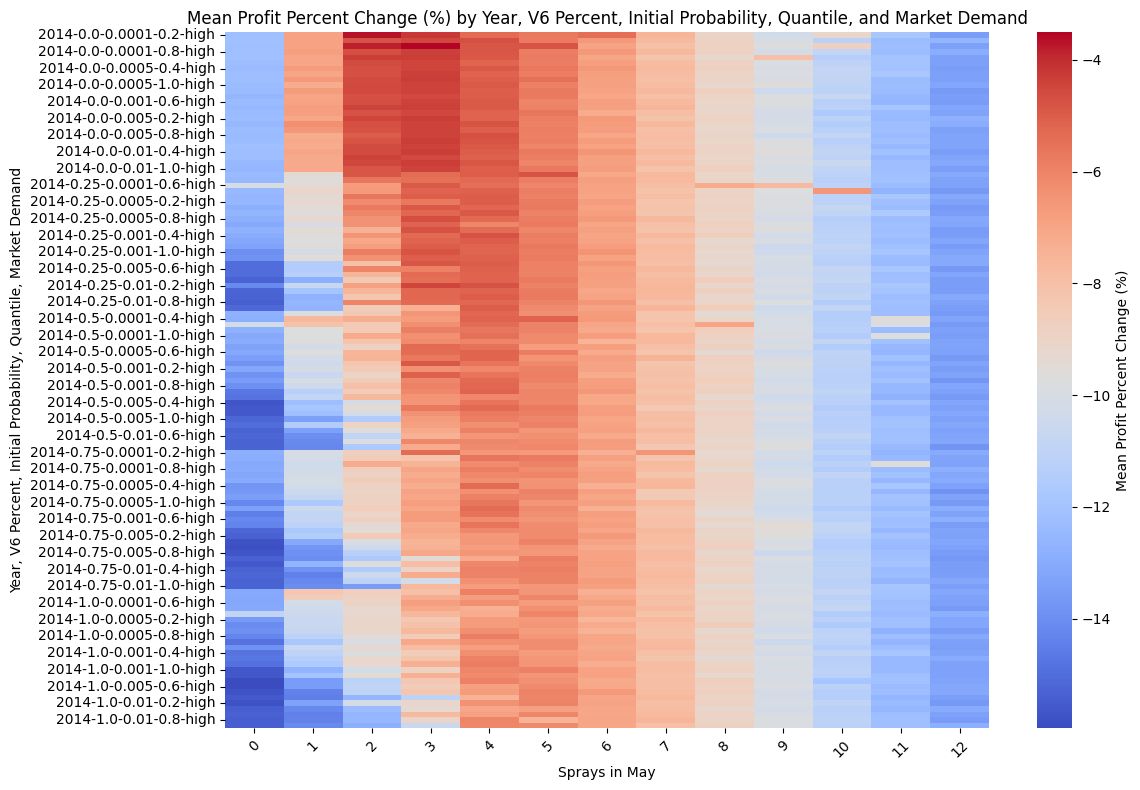

In [11]:
# plot heatmap for given year, v6 percent, initial probability, quantile, and market demand
df['Year'] = df['Year'].astype(str)
df['V6 Percent'] = df['V6 Percent'].astype(str)
df['Initial Probability'] = df['Initial Probability'].astype(str)
df['Quantile'] = df['Quantile'].astype(str)
df['Market Demand'] = df['Market Demand'].astype(str)
df['Simulation'] = df['Simulation'].astype(str)

# Create a pivot table
pivot = pd.pivot_table(df, values='Mean Profit Percent Change', index=['Year', 'V6 Percent', 'Initial Probability', 'Quantile', 'Market Demand'], columns='Sprays in May')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='coolwarm', annot=False, fmt=".2f", cbar_kws={'label': 'Mean Profit Percent Change (%)'})
plt.title('Mean Profit Percent Change (%) by Year, V6 Percent, Initial Probability, Quantile, and Market Demand')
plt.xlabel('Sprays in May')
plt.ylabel('Year, V6 Percent, Initial Probability, Quantile, Market Demand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

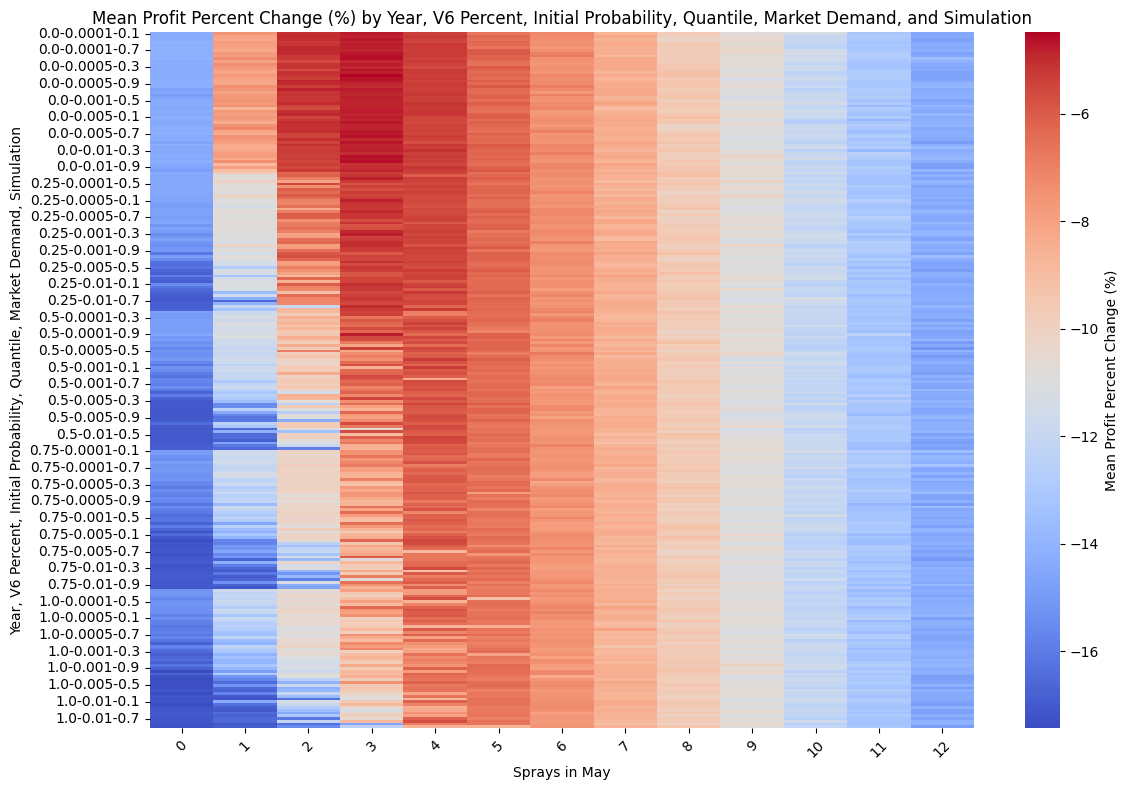

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined and contains the necessary data

# Convert columns to string type for consistent labeling
df['Year'] = df['Year'].astype(str)
df['V6 Percent'] = df['V6 Percent'].astype(str)
df['Initial Probability'] = df['Initial Probability'].astype(str)
df['Quantile'] = df['Quantile'].astype(str)
df['Market Demand'] = df['Market Demand'].astype(str)
df['Simulation'] = df['Simulation'].astype(str)

# Create a pivot table including the Simulation column in the index
pivot = pd.pivot_table(
    df, 
    values='Mean Profit Percent Change', 
    index=['V6 Percent', 'Initial Probability', 'Quantile'], 
    columns='Sprays in May',
    aggfunc='mean'  # Ensure the aggregation function is mean
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='coolwarm', annot=False, fmt=".2f", cbar_kws={'label': 'Mean Profit Percent Change (%)'})
plt.title('Mean Profit Percent Change (%) by Year, V6 Percent, Initial Probability, Quantile, Market Demand, and Simulation')
plt.xlabel('Sprays in May')
plt.ylabel('Year, V6 Percent, Initial Probability, Quantile, Market Demand, Simulation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

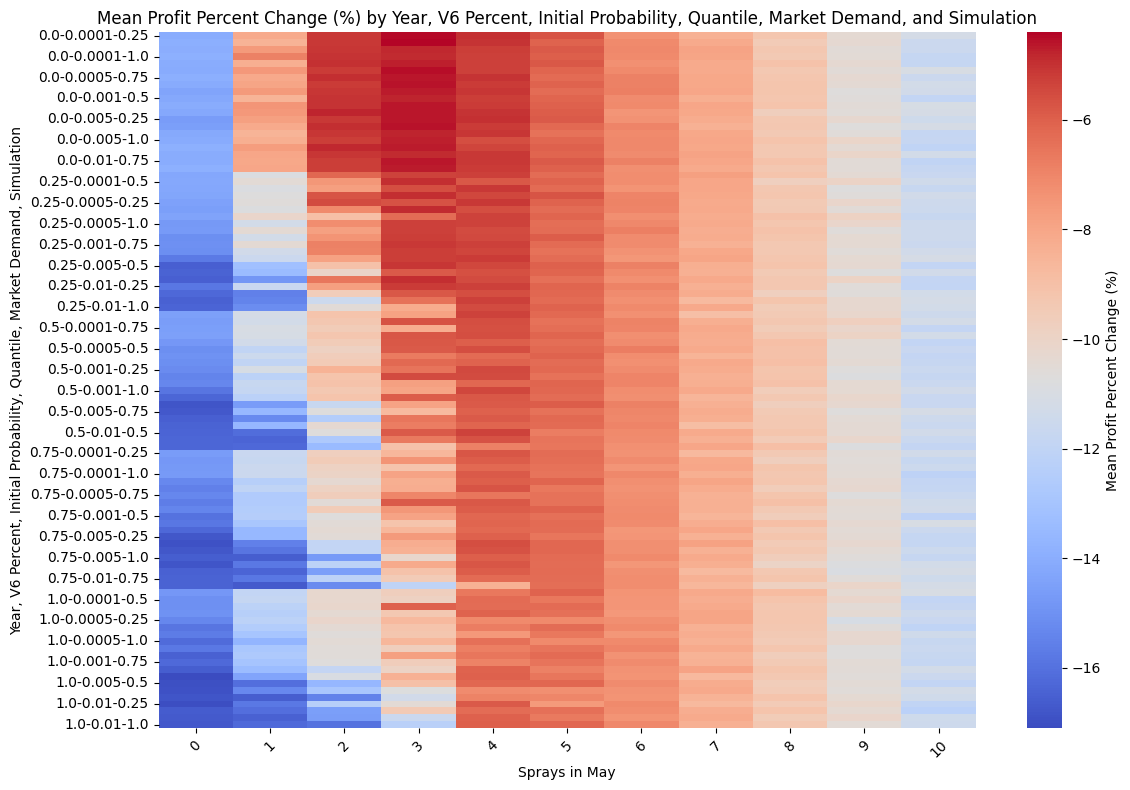

In [137]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined and contains the necessary data

# Convert columns to string type for consistent labeling
df['Year'] = df['Year'].astype(str)
df['V6 Percent'] = df['V6 Percent'].astype(str)
df['Initial Probability'] = df['Initial Probability'].astype(str)
df['Quantile'] = df['Quantile'].astype(str)
df['Market Demand'] = df['Market Demand'].astype(str)
df['Simulation'] = df['Simulation'].astype(str)

# Create a pivot table including the Simulation column in the index
pivot = pd.pivot_table(
    df, 
    values='Mean Profit Percent Change', 
    index=['V6 Percent', 'Initial Probability', 'Quantile'], 
    columns='Sprays in May',
    aggfunc='median'  # Ensure the aggregation function is mean
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='coolwarm', annot=False, fmt=".2f", cbar_kws={'label': 'Mean Profit Percent Change (%)'})
plt.title('Mean Profit Percent Change (%) by Year, V6 Percent, Initial Probability, Quantile, Market Demand, and Simulation')
plt.xlabel('Sprays in May')
plt.ylabel('Year, V6 Percent, Initial Probability, Quantile, Market Demand, Simulation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

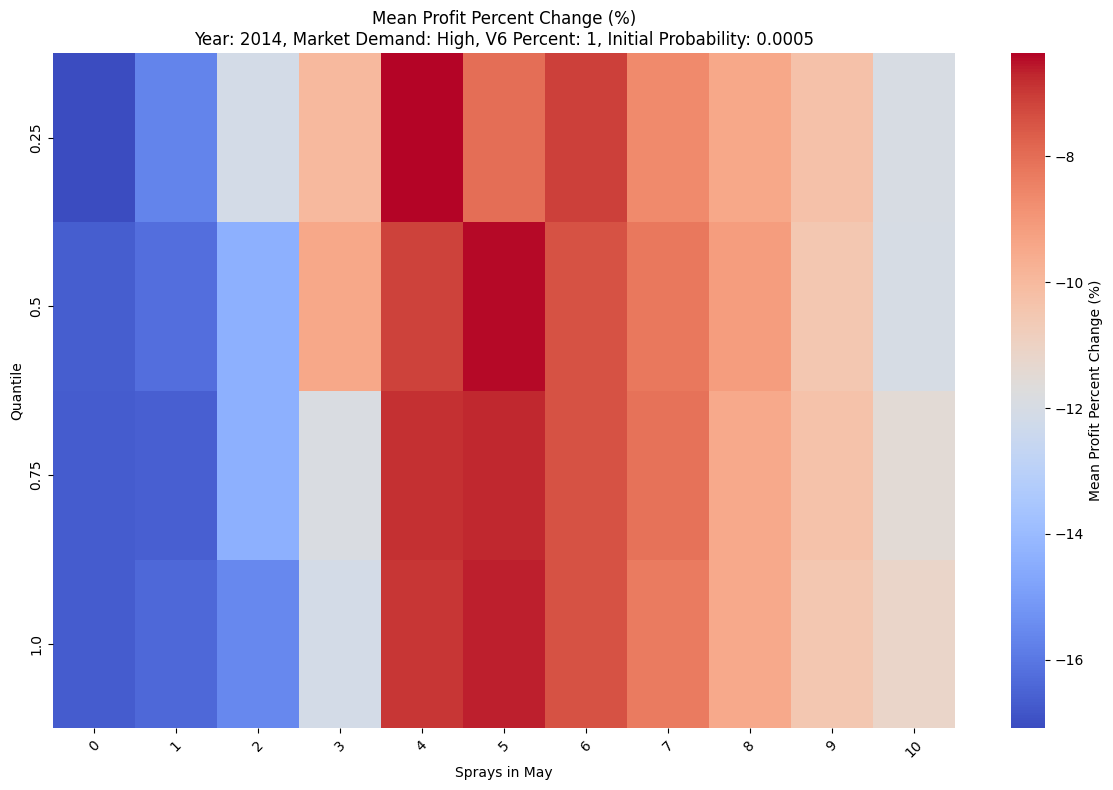

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure required columns are in appropriate data types
df['Year'] = df['Year'].astype(int)
df['V6 Percent'] = df['V6 Percent'].astype(float)
df['Initial Probability'] = df['Initial Probability'].astype(float)
df['Market Demand'] = df['Market Demand'].astype(str)
df['Simulation'] = df['Simulation'].astype(str)

# Filter the DataFrame for specified conditions
df_filtered = df[
    (df['Year'] == 2014) &
    (df['Market Demand'] == 'high') &
    (df['V6 Percent'] == 1.0) &
    (df['Initial Probability'] == 0.01)
]

# Create a pivot table
pivot = pd.pivot_table(
    df_filtered,
    values='Mean Profit Percent Change',
    index='Quantile',              # Replace with 'Quantile' if appropriate
    columns='Sprays in May',
    aggfunc='mean'               # Aggregating over 'Simulation'
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot,
    cmap='coolwarm',
    annot=False,
    fmt=".2f",
    cbar_kws={'label': 'Mean Profit Percent Change (%)'}
)
plt.title('Mean Profit Percent Change (%)\nYear: 2014, Market Demand: High, V6 Percent: 1, Initial Probability: 0.0005')
plt.xlabel('Sprays in May')
plt.ylabel('Quantile')  # Use 'Quantile' if that's your index
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [132]:
# create list of names
names = ['julie', 'john', 'jason', 'joshua', 'doris', 'haifeng']

# shuffle names and create two teams
np.random.shuffle(names)
team1 = names[:len(names)//2]
team2 = names[len(names)//2:]

# print teams
print('Team 1:', team1)
print('Team 2:', team2)

Team 1: ['jason', 'john', 'doris']
Team 2: ['haifeng', 'julie', 'joshua']


In [2]:
variety_df

Susceptibility1 Susceptibility2  Variety
0                0               1  chinook
1                1               0   mosaic
2                0               1  chinook
3                1               0   nugget
4                0               1  chinook
..             ...             ...      ...
94               0               1  chinook
95               1               0   nugget
96               0               1   simcoe
97               0               1  chinook
98               1               0   nugget

[99 rows x 3 columns]

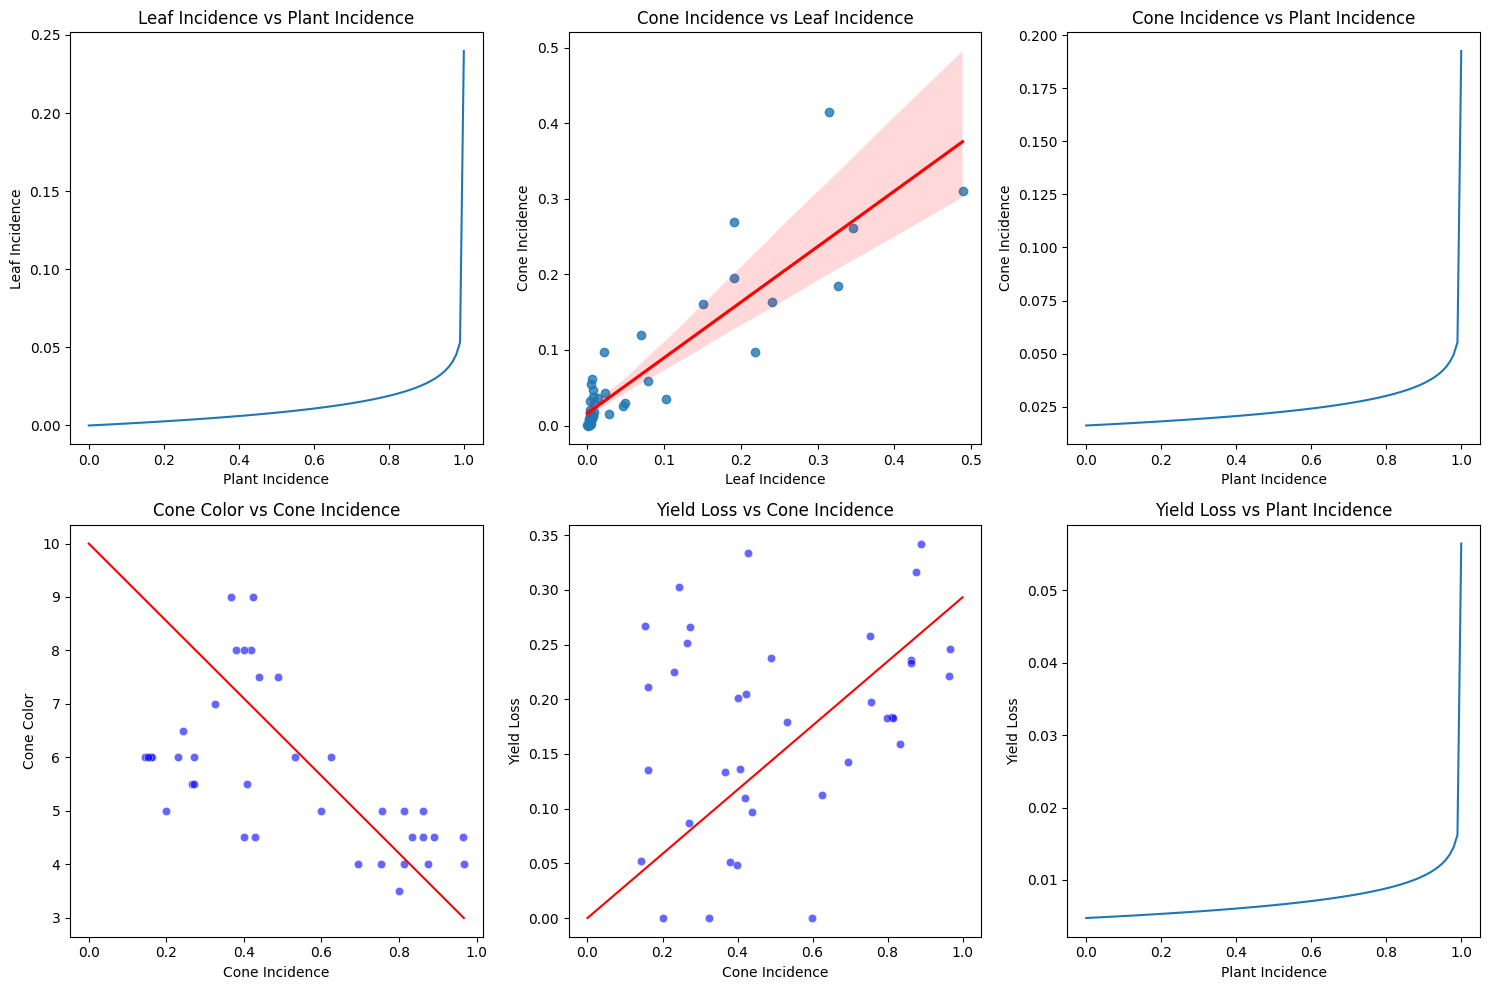

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the leaf_incidence function
def leaf_incidence_function(plant_incidence, n_leaves=100, D=1.19):
    plant_incidence = plant_incidence - 1e-10
    n_D = n_leaves / D
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    return leaf_incidence

# Define the exponential decay function that passes through (0, 10)
def exp_decreasing(x, a3, b3):
    return 10 + a3 * (1 - np.exp(-b3 * x))

# Create a grid of subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Leaf incidence vs Plant incidence
plant_incidence_vals = np.linspace(0, 1, 100)
leaf_incidence_vals = leaf_incidence_function(plant_incidence_vals)
sns.lineplot(x=plant_incidence_vals, y=leaf_incidence_vals, ax=axes[0, 0])
axes[0, 0].set_xlabel('Plant Incidence')
axes[0, 0].set_ylabel('Leaf Incidence')
axes[0, 0].set_title('Leaf Incidence vs Plant Incidence')

# 2. Cone incidence vs Leaf incidence
sns.regplot(x=data_cone_incidence_leaf_incidence[:, 0], y=data_cone_incidence_leaf_incidence[:, 1], ax=axes[0, 1], line_kws={'color': 'red'})
axes[0, 1].set_xlabel('Leaf Incidence')
axes[0, 1].set_ylabel('Cone Incidence')
axes[0, 1].set_title('Cone Incidence vs Leaf Incidence')

# 3. Cone incidence vs Plant incidence
plant_incidence_vals = np.linspace(0, 1, 100)
leaf_incidence_vals = leaf_incidence_function(plant_incidence_vals)
cone_incidence_vals = a1 * leaf_incidence_vals + b1
sns.lineplot(x=plant_incidence_vals, y=cone_incidence_vals, ax=axes[0, 2])
axes[0, 2].set_xlabel('Plant Incidence')
axes[0, 2].set_ylabel('Cone Incidence')
axes[0, 2].set_title('Cone Incidence vs Plant Incidence')

# 4. Cone color vs Cone incidence (regression)
sns.scatterplot(x=data_cone_color_cone_incidence[:, 0], y=data_cone_color_cone_incidence[:, 1], 
                alpha=0.6, color='blue', ax=axes[1, 0])
x_vals = np.linspace(0, data_cone_color_cone_incidence[:, 0].max(), 100)
y_vals = exp_decreasing(x_vals, a3, b3)
axes[1, 0].plot(x_vals, y_vals, color='red')
axes[1, 0].set_xlabel('Cone Incidence')
axes[1, 0].set_ylabel('Cone Color')
axes[1, 0].set_title('Cone Color vs Cone Incidence')

# 5. Yield loss vs Cone incidence (regression)
sns.scatterplot(x=data_yield_loss_cone_incidence[:, 0], y=data_yield_loss_cone_incidence[:, 1], 
                alpha=0.6, color='blue', ax=axes[1, 1])

# Plot the regression line passing through origin
x_line = np.linspace(0, 1, 100)
y_line = linear_func(x_line, a2)
axes[1, 1].plot(x_line, y_line, color='red', label=f'Regression through origin (y = {a2:.4f}x)')
axes[1, 1].set_xlabel('Cone Incidence')
axes[1, 1].set_ylabel('Yield Loss')
axes[1, 1].set_title('Yield Loss vs Cone Incidence')

# 6. Yield loss vs Plant incidence
plant_incidence_vals = np.linspace(0, 1, 100)
leaf_incidence_vals = leaf_incidence_function(plant_incidence_vals)
cone_incidence_vals = a1 * leaf_incidence_vals + b1
yield_loss_vals = a2 * cone_incidence_vals
sns.lineplot(x=plant_incidence_vals, y=yield_loss_vals, ax=axes[1, 2])
axes[1, 2].set_xlabel('Plant Incidence')
axes[1, 2].set_ylabel('Yield Loss')
axes[1, 2].set_title('Yield Loss vs Plant Incidence')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

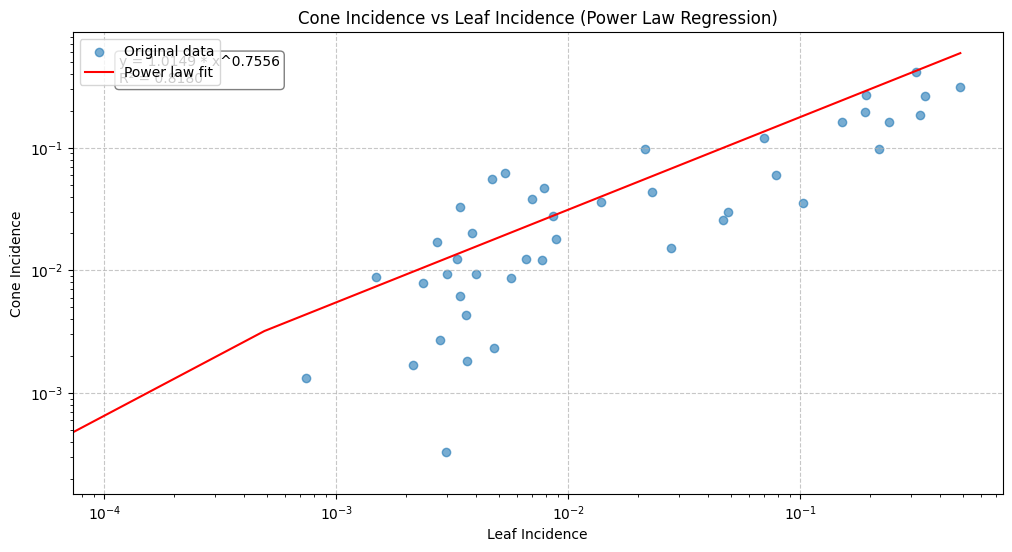

Power law regression results:
y = 1.0149 * x^0.7556
R-squared: 0.8180
p-value: 0.0000


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load and preprocess data (as before)
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()

x = data_cone_incidence_leaf_incidence[:, 0]
y = data_cone_incidence_leaf_incidence[:, 1]

# Apply log transformation
log_x = np.log1p(x)
log_y = np.log1p(y)

# Perform linear regression on log-transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)

# Convert parameters to power law form
alpha = np.exp(intercept)
beta = slope

# Create the plot
plt.figure(figsize=(12, 6))

# Plot original data
plt.scatter(x, y, alpha=0.6, label='Original data')

# Plot power law fit
x_line = np.linspace(x.min(), x.max(), 1000)
y_line = alpha * x_line**beta
plt.plot(x_line, y_line, color='red', label='Power law fit')

# Set labels and title
plt.xlabel('Leaf Incidence')
plt.ylabel('Cone Incidence')
plt.title('Cone Incidence vs Leaf Incidence (Power Law Regression)')

# Use log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add legend
plt.legend()

# Add text box with regression equation and R-squared
equation = f'y = {alpha:.4f} * x^{beta:.4f}'
r_squared = f'R² = {r_value**2:.4f}'
plt.text(0.05, 0.95, f'{equation}\n{r_squared}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.5})

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print the regression results
print(f"Power law regression results:")
print(f"y = {alpha:.4f} * x^{beta:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")

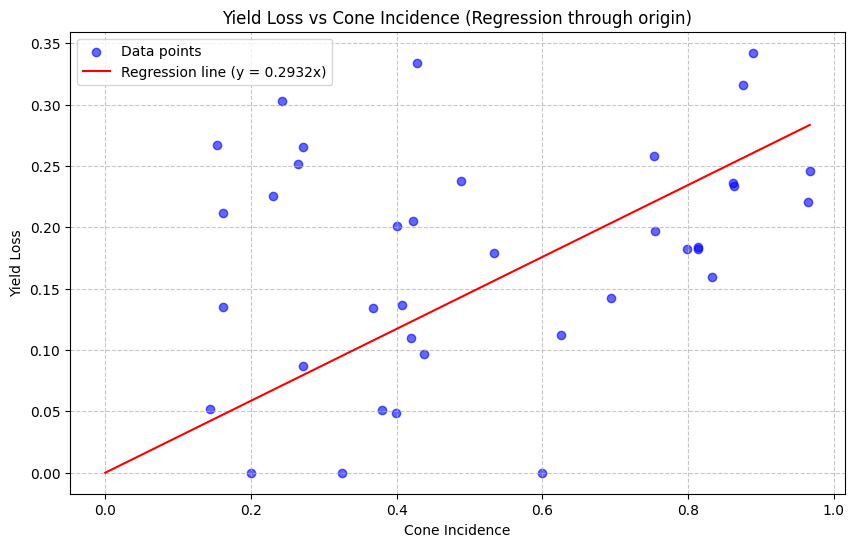

The estimated slope of the regression line is: 0.2932


In [19]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the data
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone  color_vs_Yield_loss.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Convert to numpy array
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()

# Define the linear function passing through origin
def linear_func(x, m):
    return m * x

# Fit the function to the data
slope, _ = curve_fit(linear_func, data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1])

# Extract the slope
a2 = slope[0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 
            color='blue', alpha=0.6, label='Data points')

# Plot the regression line
x_line = np.linspace(0, np.max(data_yield_loss_cone_incidence[:, 0]), 100)
y_line = linear_func(x_line, a2)
plt.plot(x_line, y_line, color='red', label=f'Regression line (y = {a2:.4f}x)')

# Set labels and title
plt.xlabel('Cone Incidence')
plt.ylabel('Yield Loss')
plt.title('Yield Loss vs Cone Incidence (Regression through origin)')

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print the slope
print(f"The estimated slope of the regression line is: {a2:.4f}")

## Heatmap

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Base directory for the files
base_dir = "../data/processed/simulations/percent_change"

year = 2016
market = 'high'

# List of files with directory structure, including the new 0% and 25% infection rate files
files = [
    f"{base_dir}/df_profit_all_0percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_0percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_0percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_0percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_25percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_25percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_25percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_25percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_50percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_50percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_50percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_50percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_75percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_75percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_75percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_75percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p00001_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p0001_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p001_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p01_{market}_{year}.csv"
]

# Initialize variables to store the global min and max values
global_min = np.inf
global_max = -np.inf

# First, go through all files to determine global min and max
for file in files:
    df_profit_all = pd.read_csv(file)
    local_min = df_profit_all['mean_profit'].min()
    local_max = df_profit_all['mean_profit'].max()
    
    # Update global min and max
    if local_min < global_min:
        global_min = local_min
    if local_max > global_max:
        global_max = local_max

# Now, plot with a consistent color scale using global_min and global_max
fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # Adjust the size as needed

for i, file in enumerate(files):
    df_profit_all = pd.read_csv(file)
    pivot_profit = df_profit_all.pivot_table(values='mean_profit', index='quantile', columns='lambda_may', aggfunc=np.mean)

    row, col = i // 4, i % 4
    ax = sns.heatmap(pivot_profit, cmap="YlGnBu", annot=False, fmt=".2f", cbar=True, ax=axes[row][col], vmin=-20.0, vmax=0)
    ax.set_title(file.split('/')[-1].split('_')[3].replace("percent", "% V6") + " - " + file.split('/')[-1].split('_')[4].split('.')[0].replace("p0", "init_prob 0."))
    ax.set_xlabel('Number of Sprays in May')
    ax.set_ylabel('quantile of Distance-based Centrality')

plt.tight_layout()
plt.show()

: 

In [2]:
global_max

0.559700313816052

In [3]:
global_min

-16.818430057541704

In [6]:
fung_application_cost

36.61460672578827

In [6]:
global_min, global_max

(-16634.98355248864, -15548.81795411298)

In [8]:
global_min, global_max

(-8354.22525304185, -7512.555652876813)

C:\Users\joshf\AppData\Local\Temp\ipykernel_24780\3106221857.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


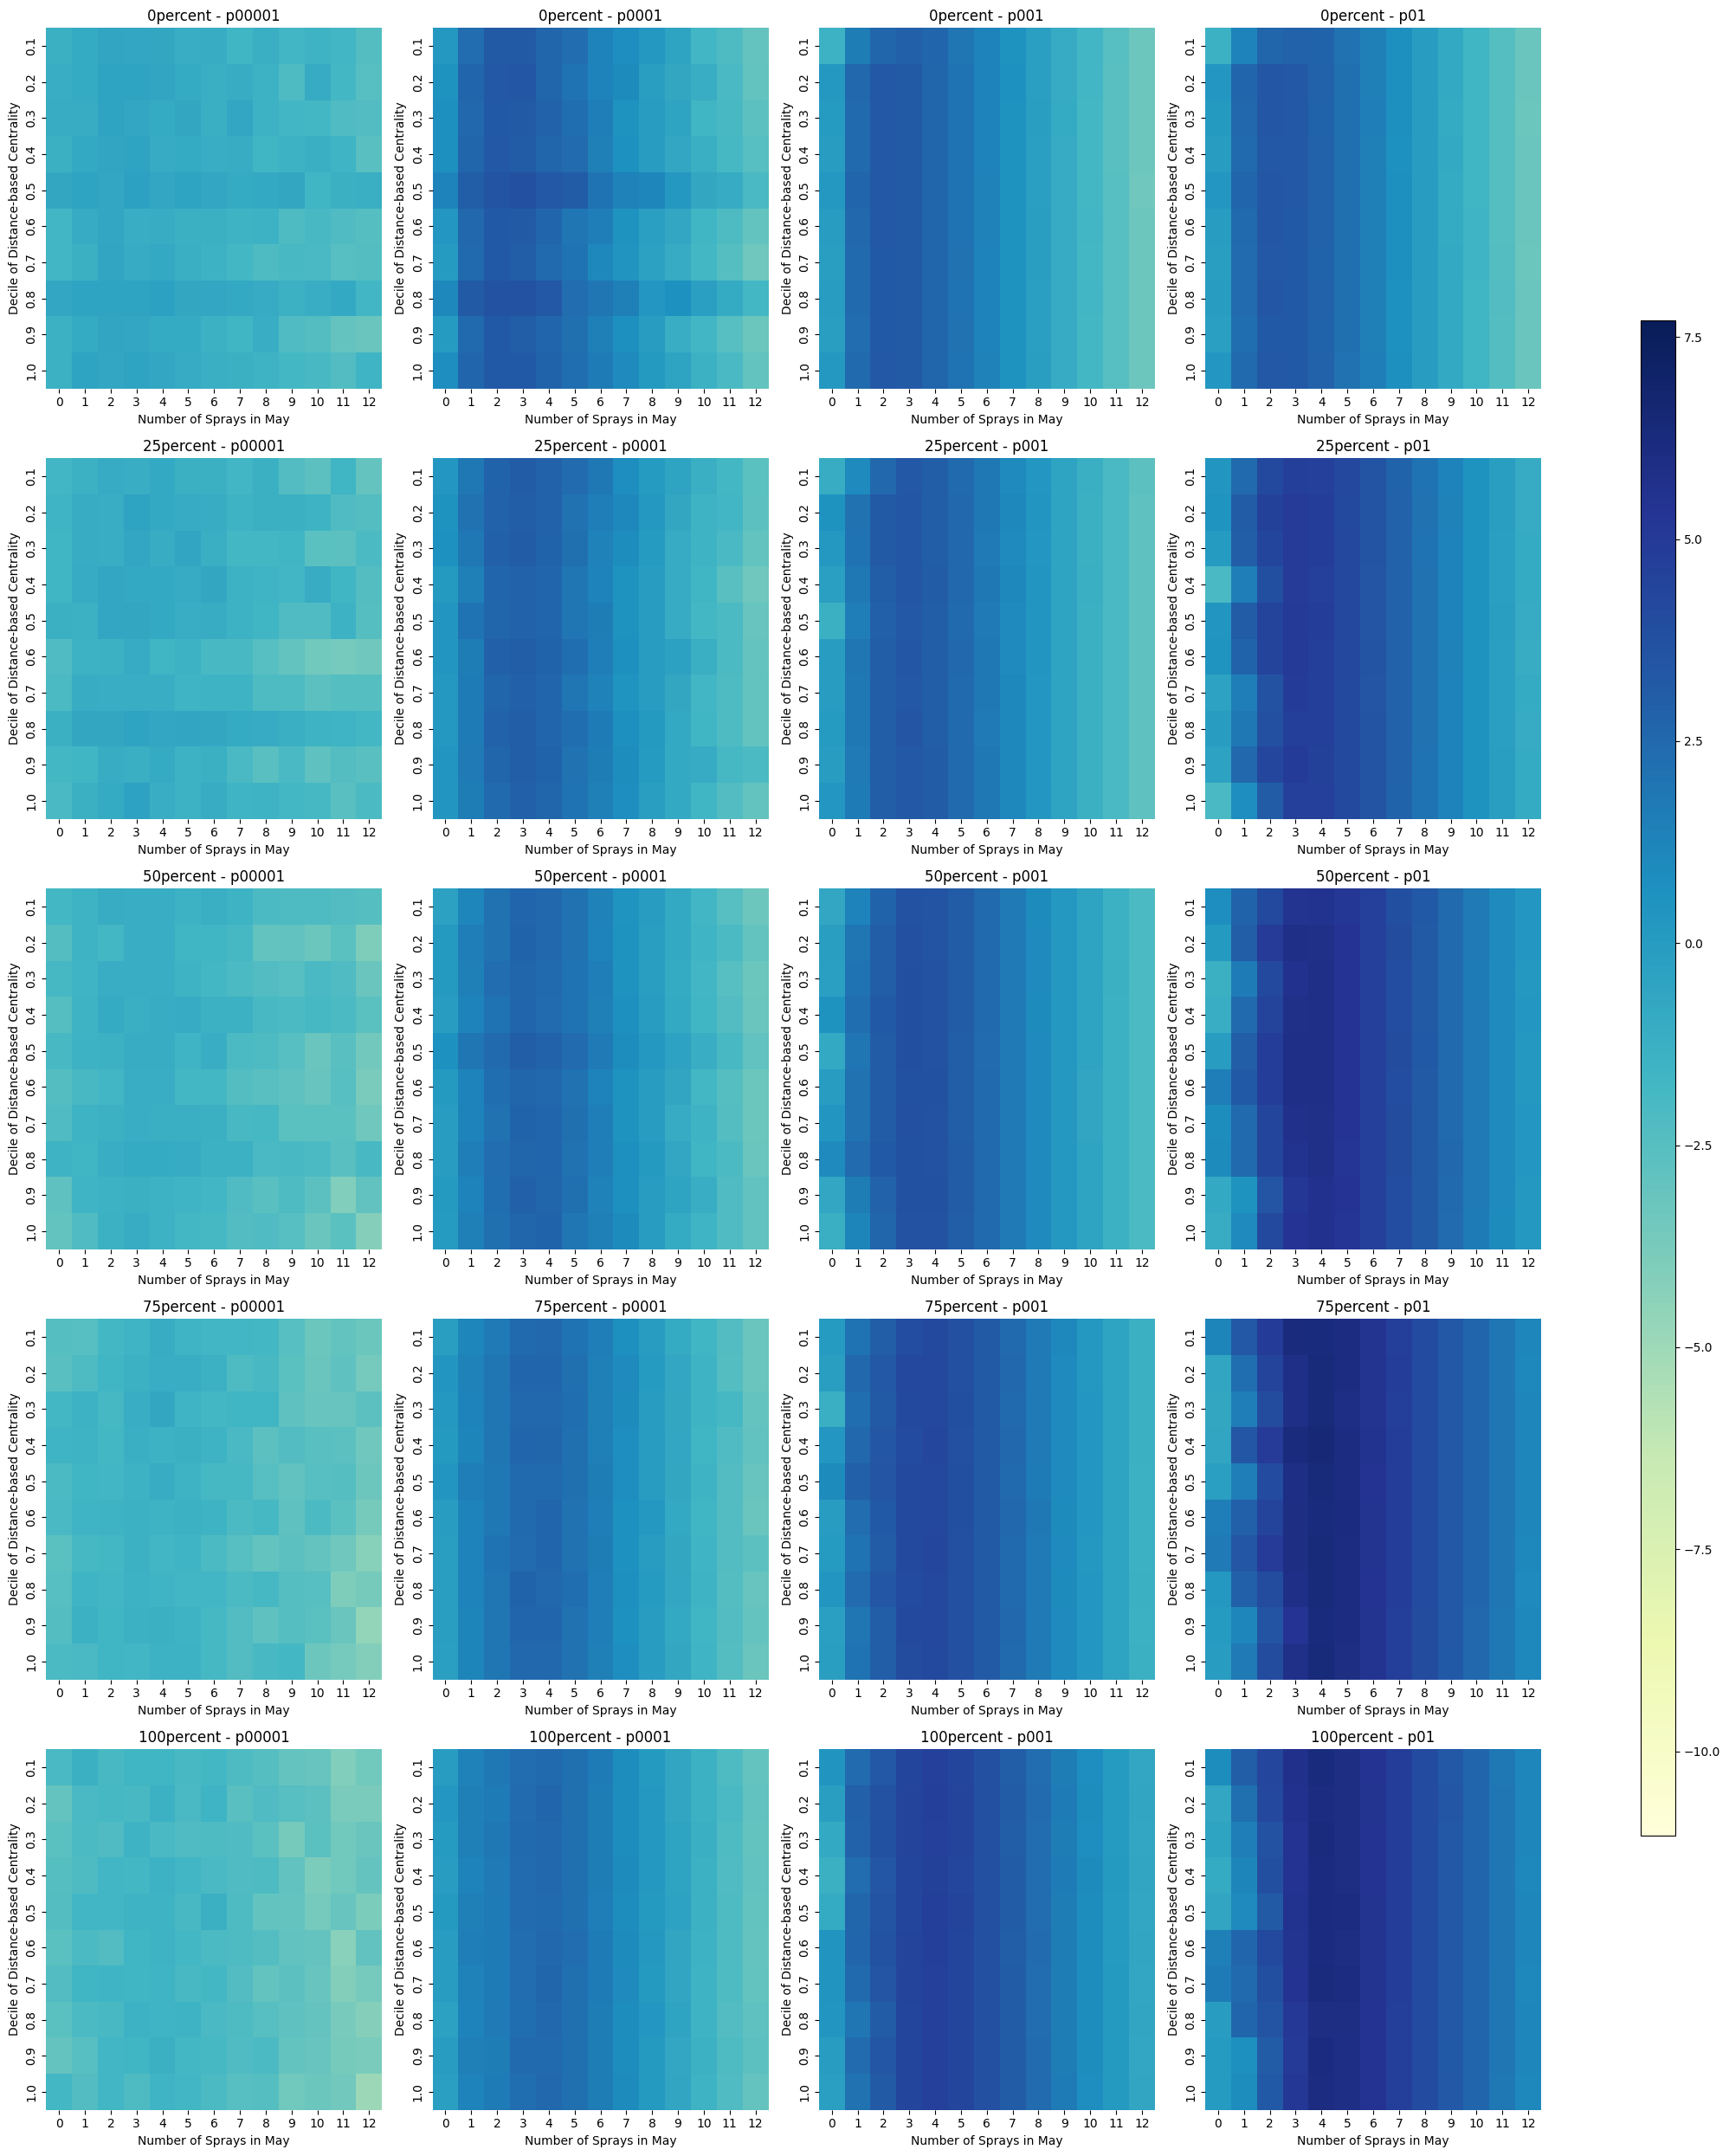

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Base directory for the files (this is just a placeholder in your actual code)
base_dir = "../data/processed/simulations/"

# List of files with directory structure
files = [
    f"{base_dir}/df_profit_all_0percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_0percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_0percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_0percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_25percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_25percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_25percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_25percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_50percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_50percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_50percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_50percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_75percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_75percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_75percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_75percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p00001_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p0001_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p001_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p01_2017.csv"
]

# Initialize variables to store the global min and max values
global_min = float('inf')
global_max = float('-inf')

# First, iterate over files to find the global min and max values for 'mean_profit'
for file in files:
    df_profit_all = pd.read_csv(file)
    local_min = df_profit_all['mean_profit'].min()
    local_max = df_profit_all['mean_profit'].max()
    global_min, global_max = min(global_min, local_min), max(global_max, local_max)

# Now, set up the matplotlib figure with 5x4 layout
fig, axes = plt.subplots(5, 4, figsize=(20, 25))

# Then, plot each heatmap with the uniform color scale
for i, file in enumerate(files):
    # Load the data
    df_profit_all = pd.read_csv(file)

    # Create pivot table
    pivot_profit = df_profit_all.pivot_table(values='mean_profit', index='quantile', columns='lambda_may', aggfunc=np.mean)

    # Plot heatmap with uniform color scale
    row, col = i // 4, i % 4
    sns.heatmap(pivot_profit, cmap="YlGnBu", annot=False, fmt=".2f",
                cbar=False, ax=axes[row][col], vmin=global_min, vmax=global_max)
    axes[row][col].set_title(file.split('/')[-1].split('_')[3] + " - " + file.split('/')[-1].split('_')[4].split('.')[0])
    axes[row][col].set_xlabel('Number of Sprays in May')
    axes[row][col].set_ylabel('quantile of Distance-based Centrality')

# Add a common color bar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [7]:
m

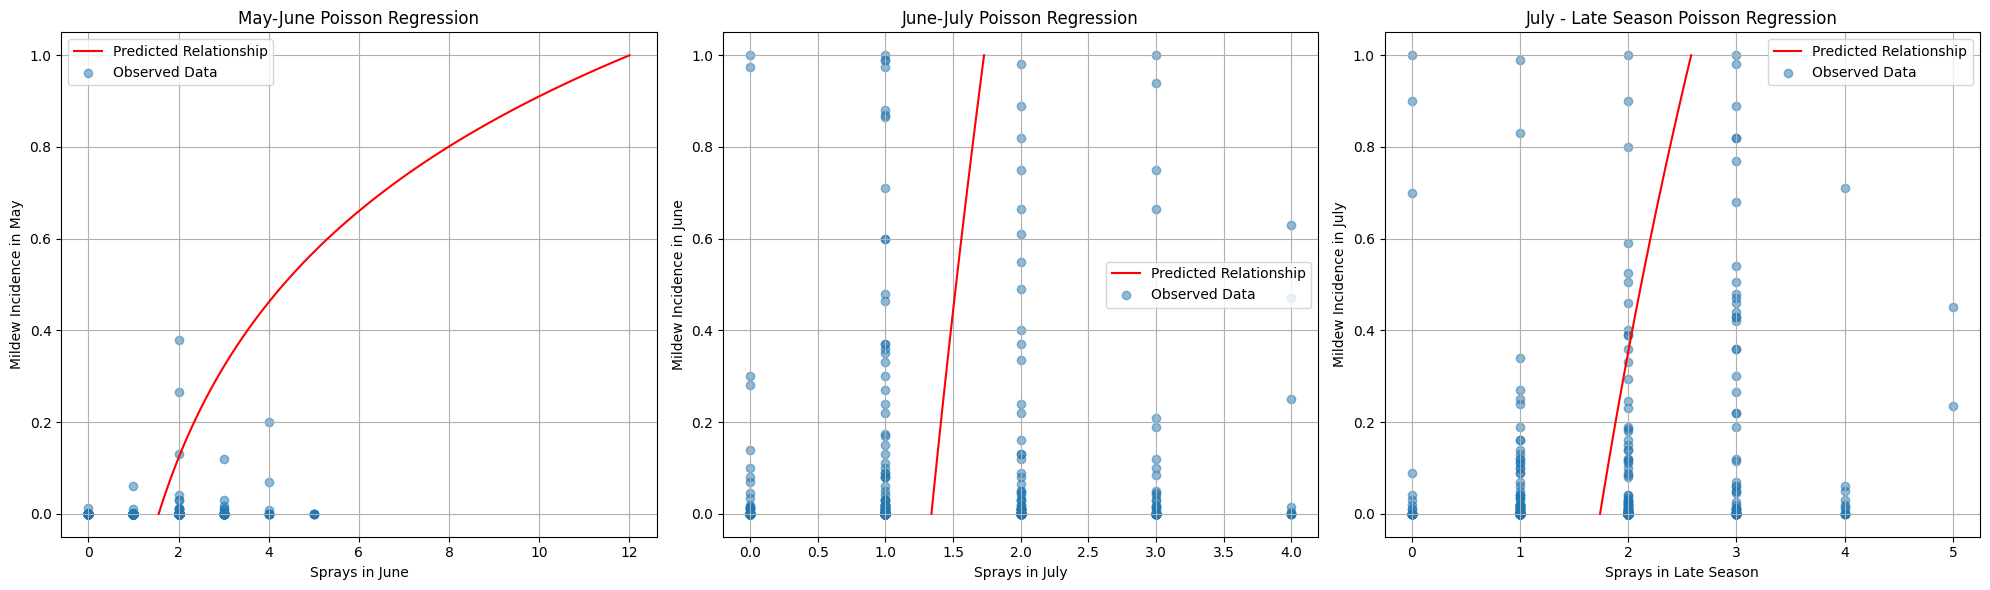

In [2]:
# SYNTHETIC SPRAY DATA / POISSON REGRESSION

import pandas as pd
import statsmodels.api as sm

# MAY-JUNE
# Define the dependent (response) variable and the independent (predictor) variable
X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_may = sm.add_constant(X_may)

# Fit the Poisson regression model
pois_may_jun = sm.GLM(y_jun, X_may, family=sm.families.Poisson()).fit()


# JUNE-JULY
# Define the dependent (response) variable and the independent (predictor) variable
X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_jun = sm.add_constant(X_jun)

# Fit the Poisson regression model
pois_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.Poisson()).fit()

# JULY-LATE SEASON
late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

# Define the dependent (response) variable and the independent (predictor) variable
X_jul = df[(df['Month'] == 'July')]['Mildew Incidence'].reset_index(drop=True)
y_late = late_df['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_jul = sm.add_constant(X_jul)

# Fit the Poisson regression model
pois_jul_late = sm.GLM(y_late, X_jul, family=sm.families.Poisson()).fit()
# END JULY-LATE SEASON

# Print the summary of the regression
#print(model.summary())


# Generate a range of mildew incidence values
mildew_range = np.linspace(0, 1, 100)

# Create a DataFrame with these values and a constant
predict_df = pd.DataFrame({'Mildew Incidence': mildew_range})
predict_df = sm.add_constant(predict_df)

# Predict the number of sprays for May-June and June-July
predicted_sprays_may_jun = pois_may_jun.predict(predict_df)
predicted_sprays_jun_jul = pois_jun_jul.predict(predict_df)
predicted_sprays_late = pois_jul_late.predict(predict_df)

# Create a figure and a 1x2 grid of subplots
plt.figure(figsize=(20, 6))

# May-June Poisson Regression
plt.subplot(1, 3, 1)
plt.plot(predicted_sprays_may_jun, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_jun, X_may['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in May')
plt.xlabel('Sprays in June')
plt.legend()
plt.title('May-June Poisson Regression')
plt.grid(True)

# June-July Poisson Regression
plt.subplot(1, 3, 2)
plt.plot(predicted_sprays_jun_jul, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_jul, X_jun['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in June')
plt.xlabel('Sprays in July')
plt.legend()
plt.title('June-July Poisson Regression')
plt.grid(True)

# July-Late season Poisson Regression
plt.subplot(1, 3, 3)
plt.plot(predicted_sprays_late, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_late, X_jul['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in July')
plt.xlabel('Sprays in Late Season')
plt.legend()
plt.title('July - Late Season Poisson Regression')
plt.grid(True)

plt.tight_layout()
plt.show()

e:\Google Drive\Github\policy-optimization\venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
e:\Google Drive\Github\policy-optimization\venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
e:\Google Drive\Github\policy-optimization\venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Deviance ratios (Poisson):
May-June: 0.90
June-July: 0.96
July-Late: 0.63
May-June Overdispersion Check:
Mean: 1.5733333333333333, Variance: 1.1137639198218263
June-July Overdispersion Check:
Mean: 1.3666666666666667, Variance: 1.0746102449888641
July-Late Overdispersion Check:
Mean: 1.7955555555555556, Variance: 0.9202474634991339


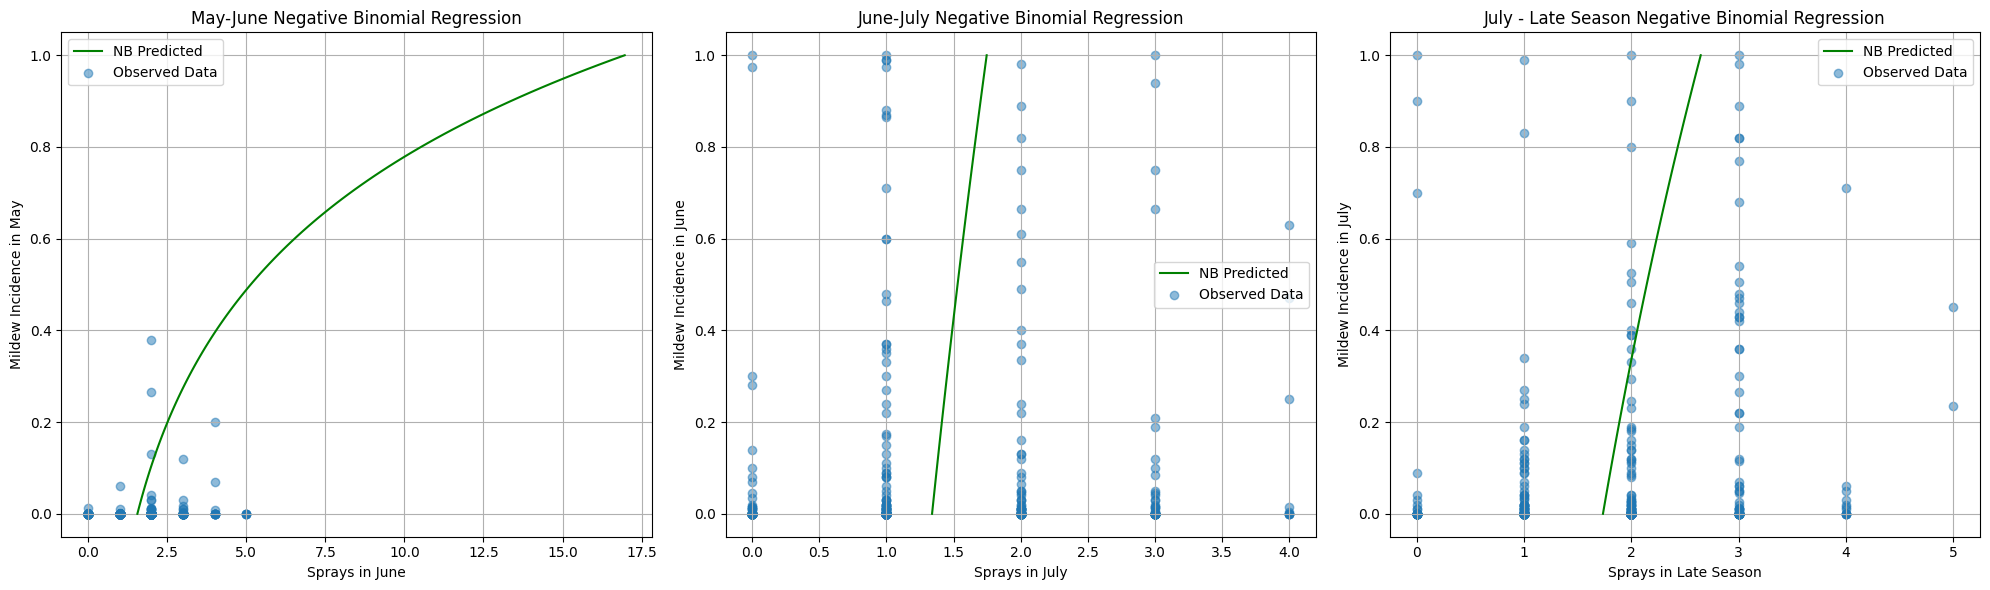

In [4]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Fit Negative Binomial Models
nb_may_jun = sm.GLM(y_jun, X_may, family=sm.families.NegativeBinomial()).fit()
nb_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.NegativeBinomial()).fit()
nb_jul_late = sm.GLM(y_late, X_jul, family=sm.families.NegativeBinomial()).fit()

# Check for overdispersion in Poisson models
pois_may_jun_deviance = pois_may_jun.deviance / pois_may_jun.df_resid
pois_jun_jul_deviance = pois_jun_jul.deviance / pois_jun_jul.df_resid
pois_jul_late_deviance = pois_jul_late.deviance / pois_jul_late.df_resid

print("Deviance ratios (Poisson):")
print(f"May-June: {pois_may_jun_deviance:.2f}")
print(f"June-July: {pois_jun_jul_deviance:.2f}")
print(f"July-Late: {pois_jul_late_deviance:.2f}")

# Variance and Mean checks
print("May-June Overdispersion Check:")
print(f"Mean: {y_jun.mean()}, Variance: {y_jun.var()}")
print("June-July Overdispersion Check:")
print(f"Mean: {y_jul.mean()}, Variance: {y_jul.var()}")
print("July-Late Overdispersion Check:")
print(f"Mean: {y_late.mean()}, Variance: {y_late.var()}")

# Predict with Negative Binomial
predicted_sprays_nb_may_jun = nb_may_jun.predict(predict_df)
predicted_sprays_nb_jun_jul = nb_jun_jul.predict(predict_df)
predicted_sprays_nb_late = nb_jul_late.predict(predict_df)

# Plot Negative Binomial predictions
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.plot(predicted_sprays_nb_may_jun, mildew_range, '-g', label='NB Predicted')
plt.scatter(y_jun, X_may['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in May')
plt.xlabel('Sprays in June')
plt.legend()
plt.title('May-June Negative Binomial Regression')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(predicted_sprays_nb_jun_jul, mildew_range, '-g', label='NB Predicted')
plt.scatter(y_jul, X_jun['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in June')
plt.xlabel('Sprays in July')
plt.legend()
plt.title('June-July Negative Binomial Regression')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(predicted_sprays_nb_late, mildew_range, '-g', label='NB Predicted')
plt.scatter(y_late, X_jul['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in July')
plt.xlabel('Sprays in Late Season')
plt.legend()
plt.title('July - Late Season Negative Binomial Regression')
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson

# Function to fit ZIP model and display results
def fit_zip(X, y):
    # Fit the Zero-Inflated Poisson model
    zip_model = ZeroInflatedPoisson(y, X, inflation='logit').fit(disp=0)
    return zip_model

# MAY-JUNE
X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)
X_may = sm.add_constant(X_may)

zip_may_jun = fit_zip(X_may, y_jun)

# JUNE-JULY
X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)
X_jun = sm.add_constant(X_jun)

zip_jun_jul = fit_zip(X_jun, y_jul)

# JULY-LATE SEASON
X_jul = df[(df['Month'] == 'July')]['Mildew Incidence'].reset_index(drop=True)
y_late = late_df['Sprays'].reset_index(drop=True)
X_jul = sm.add_constant(X_jul)

zip_jul_late = fit_zip(X_jul, y_late)

# Display results
print("May-June ZIP Model:\n", zip_may_jun.summary())
print("\nJune-July ZIP Model:\n", zip_jun_jul.summary())
print("\nJuly-Late ZIP Model:\n", zip_jul_late.summary())


May-June ZIP Model:
                      ZeroInflatedPoisson Regression Results                    
Dep. Variable:                  Sprays   No. Observations:                  450
Model:             ZeroInflatedPoisson   Df Residuals:                      448
Method:                            MLE   Df Model:                            1
Date:                 Fri, 20 Dec 2024   Pseudo R-squ.:                0.002175
Time:                         14:25:53   Log-Likelihood:                -663.10
converged:                        True   LL-Null:                       -664.55
Covariance Type:             nonrobust   LLR p-value:                   0.08912
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
inflate_const      -58.7372   8.08e+06  -7.27e-06      1.000   -1.58e+07    1.58e+07
const                0.4447      0.038     11.702      0.000       0.370       0.519

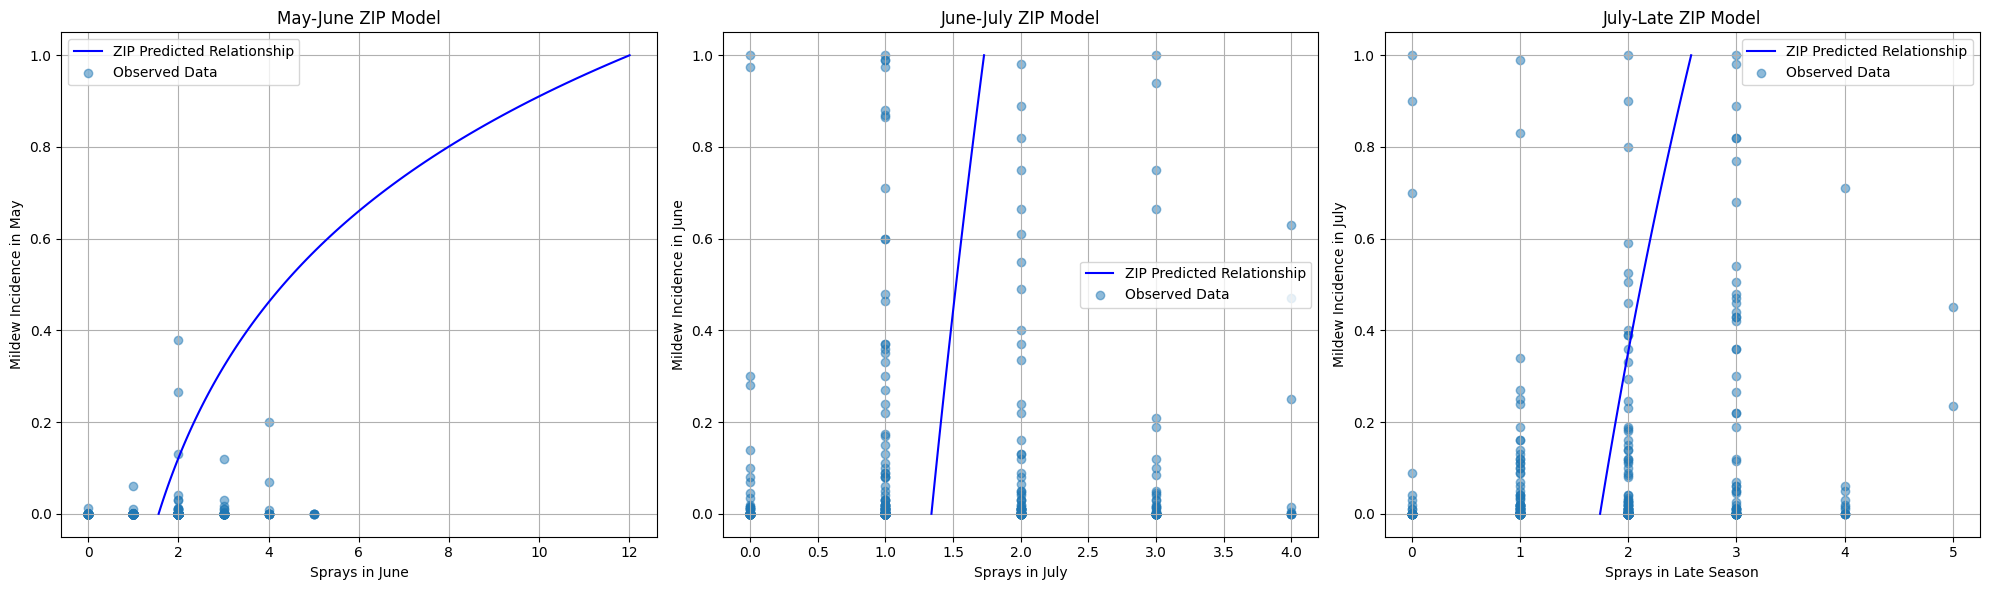

In [6]:
# Generate predictions for May-June ZIP model
predict_df = pd.DataFrame({'Mildew Incidence': mildew_range})
predict_df = sm.add_constant(predict_df)

predicted_sprays_may_jun_zip = zip_may_jun.predict(predict_df)
predicted_sprays_jun_jul_zip = zip_jun_jul.predict(predict_df)
predicted_sprays_late_zip = zip_jul_late.predict(predict_df)

# Plot predictions
plt.figure(figsize=(20, 6))

# May-June ZIP Model
plt.subplot(1, 3, 1)
plt.plot(predicted_sprays_may_jun_zip, mildew_range, '-b', label='ZIP Predicted Relationship')
plt.scatter(y_jun, X_may['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in May')
plt.xlabel('Sprays in June')
plt.legend()
plt.title('May-June ZIP Model')
plt.grid(True)

# June-July ZIP Model
plt.subplot(1, 3, 2)
plt.plot(predicted_sprays_jun_jul_zip, mildew_range, '-b', label='ZIP Predicted Relationship')
plt.scatter(y_jul, X_jun['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in June')
plt.xlabel('Sprays in July')
plt.legend()
plt.title('June-July ZIP Model')
plt.grid(True)

# July-Late ZIP Model
plt.subplot(1, 3, 3)
plt.plot(predicted_sprays_late_zip, mildew_range, '-b', label='ZIP Predicted Relationship')
plt.scatter(y_late, X_jul['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in July')
plt.xlabel('Sprays in Late Season')
plt.legend()
plt.title('July-Late ZIP Model')
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
# Step 1: Filter and convert to NumPy arrays
may_incidence = df[df['Month'] == 'May']['Mildew Incidence'].to_numpy()
june_incidence = df[df['Month'] == 'June']['Mildew Incidence'].to_numpy()
july_incidence = df[df['Month'] == 'July']['Mildew Incidence'].to_numpy()

# Step 2: Sum the arrays
total_incidence = may_incidence + june_incidence + july_incidence

# Step 3: Calculate the mean across the months
mean_incidence = total_incidence / 3

# Convert the mean back to a pandas Series (if needed)
mean_incidence_series = pd.Series(mean_incidence)

# JULY-LATE SEASON
late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

# Define the dependent (response) variable and the independent (predictor) variable
X_mean = mean_incidence_series.reset_index(drop=True)
y_late = late_df['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_mean = sm.add_constant(X_mean)

# Fit the Poisson regression model
pois_mean_late = sm.GLM(y_late, X_mean, family=sm.families.Poisson()).fit()

# AIC for the original model using only July
aic_july = pois_jul_late.aic

# AIC for the model using the mean incidence over May, June, and July
aic_mean = pois_mean_late.aic

print("AIC for July only model: ", aic_july)
print("AIC for mean incidence model: ", aic_mean)


AIC for July only model:  1321.4949554900054
AIC for mean incidence model:  1321.5479123827724


In [38]:
list(np.array([2.5, 4.25, 6.0]) / ppi_2021 * 100)

[2.7801462130648655, 4.726248562210271, 6.672350911355678]

In [22]:
# import parquet data
import pandas as pd
df = pd.read_parquet('../data/processed/simulations/simulations_dec6.parquet')

In [13]:
df.columns

Index(['Year', 'V6 Percent', 'Initial Probability', 'Quantile',
       'Mean Profit Percent Change', 'Sprays in May', 'Market Demand',
       'Simulation', 'Disease Incidence May', 'Disease Incidence June',
       'Disease Incidence July', 'Mean Sprays in May', 'Mean Sprays in June',
       'Mean Sprays in July', 'Mean Sprays in Late Season',
       'Mean Baseline Sprays in May', 'Mean Baseline Sprays in June',
       'Mean Baseline Sprays in July', 'Mean Baseline Sprays in Late Season',
       'Mean Fungicide Cost Early Season', 'Mean Fungicide Cost May',
       'Mean Fungicide Cost June', 'Mean Fungicide Cost July',
       'Mean Fungicide Cost Late Season', 'Mean Fungicide Cost',
       'Mean Baseline Fungicide Cost May', 'Mean Baseline Fungicide Cost June',
       'Mean Baseline Fungicide Cost July',
       'Mean Baseline Fungicide Cost Late Season',
       'Mean Baseline Fungicide Cost', 'Mean Price', 'Mean Yield',
       'Mean Baseline Price', 'Mean Baseline Yield', 'Mean Cone Col

In [12]:
1 - (1 - df['Mean Cone Incidence']) ** (100 / 1.19)

0         0.746802
1         0.746802
2         0.746802
3         0.746802
4         0.746802
            ...   
461995    0.758186
461996    0.758186
461997    0.758190
461998    0.758190
461999    0.758190
Name: Mean Cone Incidence, Length: 462000, dtype: float64

In [26]:
df['Mean Cone Incidence'].describe()

count    462000.000000
mean          0.016903
std           0.001286
min           0.016213
25%           0.016678
50%           0.016730
75%           0.016784
max           0.039773
Name: Mean Cone Incidence, dtype: float64

In [ ]:
def leaf_incidence_function(plant_incidence, n_leaves=100, D=1.19):

    plant_incidence = plant_incidence - 1e-16  # to avoid identity problem

    # n_leaves is the number of leaves sampled and D is the index of dispersion
    n_D = n_leaves / D

    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)

    return leaf_incidence

    # QUALITY METRIC
    # Function to estimate cone color given plant incidence
    def cone_color(plant_incidence):

        leaf_incidence = leaf_incidence_function(plant_incidence)

        cone_incidence = a1 * leaf_incidence + b1

        # intercept fixed at 10 since that's the highest cone color rating
        cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))

        return cone_color

In [54]:
def leaf_incidence_function(plant_incidence, n_leaves=100, D=1.19):

    plant_incidence = plant_incidence - 1e-16  # to avoid identity problem

    # n_leaves is the number of leaves sampled and D is the index of dispersion
    n_D = n_leaves / D

    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)

    return leaf_incidence

leaf_incidence_function(1)

1.0

In [56]:
def yield_loss(plant_incidence):

    leaf_incidence = leaf_incidence_function(plant_incidence)

    cone_incidence = a1 * leaf_incidence + b1

    yield_loss = a2 * cone_incidence

    return yield_loss, cone_incidence

yield_loss_, cone_incidence_ = yield_loss(1)

print(cone_incidence_, yield_loss_)

0.751579512098398 0.2203280132749247


In [30]:
df.columns

Index(['Year', 'V6 Percent', 'Initial Probability', 'Quantile',
       'Mean Profit Percent Change', 'Sprays in May', 'Market Demand',
       'Simulation', 'Disease Incidence May', 'Disease Incidence June',
       'Disease Incidence July', 'Mean Sprays in May', 'Mean Sprays in June',
       'Mean Sprays in July', 'Mean Sprays in Late Season',
       'Mean Baseline Sprays in May', 'Mean Baseline Sprays in June',
       'Mean Baseline Sprays in July', 'Mean Baseline Sprays in Late Season',
       'Mean Fungicide Cost Early Season', 'Mean Fungicide Cost May',
       'Mean Fungicide Cost June', 'Mean Fungicide Cost July',
       'Mean Fungicide Cost Late Season', 'Mean Fungicide Cost',
       'Mean Baseline Fungicide Cost May', 'Mean Baseline Fungicide Cost June',
       'Mean Baseline Fungicide Cost July',
       'Mean Baseline Fungicide Cost Late Season',
       'Mean Baseline Fungicide Cost', 'Mean Price', 'Mean Yield',
       'Mean Baseline Price', 'Mean Baseline Yield', 'Mean Cone Col